# NY Warehouse Flow Forecasting

In this notebook, we tried to predict the inbound & outbound traffic from the warehouse, in order to help allocate workforce. Noted that the max capacity of the warehouse is 3500 orders/day as of July 2019, but our predictions are not limited by that.

There are six types of warehouse activities:

Outbound customer order
Outbound items transfer
Outbound purchase order return
Inbound customer return
Inbound items transfer
Inbound purchase order

In [1]:
import pandas as pd
import numpy as np
import queries.utils as utils
from functools import reduce
from matplotlib import pyplot as plt

#### bigquery client & credentials
import os
from google.cloud import bigquery
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"C:\Users\m.young\Documents\BigQueryAPIKey\modata-79d448dbeef0.json"
client = bigquery.Client()

#### fbprophet 
import fbprophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import add_changepoints_to_plot

pd.plotting.register_matplotlib_converters() ## bugs.. fbprophet & matplotlib

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


## A. IMPORT DATA

### 1. Actuals Data

In [2]:
# Data
# data_raw_all = pd.read_csv('data/inven_est_072319.csv')


# BQ query
wh_actuals_query = """
SELECT
     *
FROM adhoc_analytics.project_inven_forecast_actuals_EST
  """

# put query results into pandas df
data_raw_all = client.query(wh_actuals_query).to_dataframe()

# convert date column to datetime data type
data_raw_all['date_est'] = pd.to_datetime(data_raw_all['date_est'])

# sort by date desc
data_raw_all.sort_values(by='date_est', inplace=True)

# reset index numbers after sort
data_raw_all.reset_index(drop=True, inplace=True)

# replace NaN with 0s
data_raw_all.fillna(0, inplace=True)

In [3]:
# View Data
display(data_raw_all.head())
display(data_raw_all.tail())

date_est  OUT_CUST_UNITS  OUT_TO_UNITS  OUT_VR_UNITS  IN_CUST_UNITS  \
0 2016-01-01             256             0             0             19   
1 2016-01-02             228             0             0              0   
2 2016-01-03             208             0             0              0   
3 2016-01-04             235             1             0            134   
4 2016-01-05             362            24             0            112   

   IN_PO_UNITS  IN_TO_UNITS  TTL_OUT_UNITS  TTL_IN_UNITS  TTL_ALL_UNITS  
0            0            0            256            19            275  
1            0            0            228             0            228  
2            0            0            208             0            208  
3          264            0            236           398            634  
4          338            0            386           450            836

date_est  OUT_CUST_UNITS  OUT_TO_UNITS  OUT_VR_UNITS  IN_CUST_UNITS  \
1336 2019-08-29             497            88             0            263   
1337 2019-08-30             365           278             3             33   
1338 2019-08-31             495            18             0              0   
1339 2019-09-01             544             5             0              0   
1340 2019-09-02             300            62             0              5   

      IN_PO_UNITS  IN_TO_UNITS  TTL_OUT_UNITS  TTL_IN_UNITS  TTL_ALL_UNITS  
1336          260           26            585           549           1134  
1337          197           27            646           257            903  
1338            0            0            513             0            513  
1339            5            0            549             5            554  
1340            0            0            340             5            345

In [4]:
data_raw_all.dtypes

date_est          datetime64[ns]
OUT_CUST_UNITS             int64
OUT_TO_UNITS               int64
OUT_VR_UNITS               int64
IN_CUST_UNITS              int64
IN_PO_UNITS                int64
IN_TO_UNITS                int64
TTL_OUT_UNITS              int64
TTL_IN_UNITS               int64
TTL_ALL_UNITS              int64
dtype: object

### 2. Excel Predictions Data

In [5]:
#### Read the current prediction data from the forecast team
dat_curr_prediction = pd.read_csv('data/inven_curr_predictions.csv')

In [6]:
display(dat_curr_prediction.tail(5))

FCST_Dt  FCT_IN_PO  FCT_IN_Return  FCT_IN_TO  FCT_IN_TOTAL  \
219  2019-12-24    1880.32         602.61      198.0       2680.94   
220  2019-12-25    1811.39         617.42        0.0       2428.81   
221  2019-12-26    1788.15         635.39      198.0       2621.54   
222  2019-12-27    1476.77         558.77      198.0       2233.54   
223  2019-12-28       0.00           0.00        0.0          0.00   

     FCT_OUT_Ord  FCT_OUT_TO  FCT_OUT_TOTAL  FCT_TOTAL  
219      1181.40       365.0        1546.40    4227.34  
220      1251.59         0.0        1251.59    3680.40  
221      1052.94       365.0        1417.94    4039.48  
222      1092.03       365.0        1457.03    3690.57  
223      1090.09         0.0        1090.09    1090.09

### 3. FB Prophet Holidays Data

In [7]:
# Outbound Customer Orders - Prophet Holidays
co_holidays = pd.read_csv('data/co_holidays.csv') # - Copy
# add employee sales dates; use promotions date table

# Inbound Purchase Orders - Prophet Holidays
po_holidays = pd.read_csv('data/po_holidays.csv')

# Inbound Customer Returns - Prophet Holidays
cr_holidays = pd.read_csv('data/cr_holidays.csv')

In [8]:
# View
display(co_holidays.tail(5))
display(po_holidays.tail(5))
display(cr_holidays.tail(5))

ds        holiday  lower_window  upper_window  flag_data
83  8/31/2017  Employee Sale             0             3        NaN
84  2/23/2018  Employee Sale             0             3        NaN
85   9/6/2018  Employee Sale             0             3        NaN
86  2/21/2019  Employee Sale             0             3        NaN
87  9/11/2019  Employee Sale             0             3        1.0

ds  holiday  lower_window  upper_window  hist_ind
13   2/11/2019  PO BULK           -14            14         1
14    4/5/2019  PO BULK           -14            14         1
15   6/17/2019  PO BULK           -14            14         1
16    8/6/2019  PO BULK            -7            28         0
17  11/20/2019  PO BULK            -7            28         0

ds holiday  lower_window  upper_window  hist_ind
23  12/10/2019   MD H2            -6             9         0
24  12/17/2019   MD H2            -6             9         0
25  12/31/2019   MD H2            -6             9         0
26    1/8/2020   MD H2            -6             9         0
27   1/16/2020   MD H2            -6             9         0

## B. Prepare Data

### 1. Prepare Actuals Data for Multiple Models

In [9]:
# Outbound - Customer Orders
co_dat = data_raw_all[['date_est','OUT_CUST_UNITS']]
co_dat = co_dat.rename(columns={'date_est':'ds','OUT_CUST_UNITS':'y'})

# Outbound - Vendor Returns
vr_dat = data_raw_all[['date_est','OUT_VR_UNITS']]
vr_dat = vr_dat.rename(columns={'date_est':'ds','OUT_VR_UNITS':'y'})

# Outbound - Transfer Orders
oto_dat = data_raw_all[['date_est','OUT_TO_UNITS']]
oto_dat = oto_dat.rename(columns={'date_est':'ds','OUT_TO_UNITS':'y'})

# Inbound - Customer Returns
cr_dat = data_raw_all[['date_est','IN_CUST_UNITS']]
cr_dat = cr_dat.rename(columns={'date_est':'ds','IN_CUST_UNITS':'y'})

# Inbound - Purchase Orders
po_dat = data_raw_all[['date_est','IN_PO_UNITS']]
po_dat = po_dat.rename(columns={'date_est':'ds','IN_PO_UNITS':'y'})

# Inbound - Transfer Orders
ito_dat = data_raw_all[['date_est','IN_TO_UNITS']]
ito_dat = ito_dat.rename(columns={'date_est':'ds','IN_TO_UNITS':'y'})

### 2. Prepare Forecast Data for Multiple Models Comparisons

In [10]:
dat_curr_prediction.head()

FCST_Dt  FCT_IN_PO  FCT_IN_Return  FCT_IN_TO  FCT_IN_TOTAL  FCT_OUT_Ord  \
0  2019-05-19       0.00           0.00        0.0          0.00      2144.79   
1  2019-05-20    1039.73          53.77      118.0       1211.50      1884.79   
2  2019-05-21     586.73          53.77      118.0        758.50      2088.79   
3  2019-05-22     506.73         115.67      118.0        740.39      1868.79   
4  2019-05-23     619.73         570.71      118.0       1308.44      1696.51   

   FCT_OUT_TO  FCT_OUT_TOTAL  FCT_TOTAL  
0         0.0        2144.79    2144.79  
1       351.0        2235.79    3447.28  
2       351.0        2439.79    3198.28  
3       351.0        2219.79    2960.18  
4       351.0        2047.51    3355.95

In [11]:
# Outbound - Customer Orders
co_dat_curr_prediction = dat_curr_prediction.loc[:,['FCST_Dt','FCT_OUT_Ord']]
co_dat_curr_prediction.rename(columns={'FCST_Dt':'ds','FCT_OUT_Ord':'excel_forecast'},inplace=True)
co_dat_curr_prediction.index = pd.to_datetime(co_dat_curr_prediction['ds'])
co_dat_curr_prediction.drop(["ds"],axis=1,inplace=True)

# Outbound - Vendor Returns


# Outbound - Transfer Orders
oto_dat_curr_prediction = dat_curr_prediction.loc[:,['FCST_Dt','FCT_OUT_TO']]
oto_dat_curr_prediction.rename(columns={'FCST_Dt':'ds','FCT_OUT_TO':'excel_forecast'},inplace=True)
oto_dat_curr_prediction.index = pd.to_datetime(oto_dat_curr_prediction['ds'])
oto_dat_curr_prediction.drop(["ds"],axis=1,inplace=True)

# Inbound - Customer Returns
cr_dat_curr_prediction = dat_curr_prediction.loc[:,['FCST_Dt','FCT_IN_Return']]
cr_dat_curr_prediction.rename(columns={'FCST_Dt':'ds','FCT_IN_Return':'excel_forecast'},inplace=True)
cr_dat_curr_prediction.index = pd.to_datetime(cr_dat_curr_prediction['ds'])
cr_dat_curr_prediction.drop(["ds"],axis=1,inplace=True)

# Inbound - Purchase Orders
po_dat_curr_prediction = dat_curr_prediction.loc[:,['FCST_Dt','FCT_IN_PO']]
po_dat_curr_prediction.rename(columns={'FCST_Dt':'ds','FCT_IN_PO':'excel_forecast'},inplace=True)
po_dat_curr_prediction.index = pd.to_datetime(po_dat_curr_prediction['ds'])
po_dat_curr_prediction.drop(["ds"],axis=1,inplace=True)

# Inbound - Transfer Orders
ito_dat_curr_prediction = dat_curr_prediction.loc[:,['FCST_Dt','FCT_IN_TO']]
ito_dat_curr_prediction.rename(columns={'FCST_Dt':'ds','FCT_IN_TO':'excel_forecast'},inplace=True)
ito_dat_curr_prediction.index = pd.to_datetime(ito_dat_curr_prediction['ds'])
ito_dat_curr_prediction.drop(["ds"],axis=1,inplace=True)

### 3. Prepare Train vs Test Datasets for FB Prophet Models

In [12]:
# Parameters Settings
split_date = '2019-09-01'  # Setting the train test cutoff date
forward_days = 200  # set up how

In [13]:
# Outbound Customer Orders
co_dat_train = co_dat.loc[co_dat.ds<split_date , :]
co_dat_test = co_dat.loc[co_dat.ds>=split_date , :]

# Outbound - Vendor Returns
vr_dat_train = vr_dat.loc[vr_dat.ds<split_date , :]
vr_dat_test = vr_dat.loc[vr_dat.ds>=split_date , :]

# Outbound - Transfer Orders
oto_dat_train = oto_dat.loc[oto_dat.ds<split_date , :]
oto_dat_test = oto_dat.loc[oto_dat.ds>=split_date , :]

# Inbound - Customer Returns
cr_dat_train = cr_dat.loc[cr_dat.ds<split_date , :]
cr_dat_test = cr_dat.loc[cr_dat.ds>=split_date , :]

# Inbound - Purchase Orders
po_dat_train = po_dat.loc[po_dat.ds<split_date , :]
po_dat_test = po_dat.loc[po_dat.ds>=split_date , :]

# Inbound - Transfer Orders
ito_dat_train = ito_dat.loc[ito_dat.ds<split_date , :]
ito_dat_test = ito_dat.loc[ito_dat.ds>=split_date , :]


In [14]:
# Outbound Customer Orders
co_dat_all = pd.concat([co_dat_train, co_dat_test])

# Outbound - Vendor Returns
vr_dat_all = pd.concat([vr_dat_train, vr_dat_test])

# Outbound - Transfer Orders
oto_dat_all = pd.concat([oto_dat_train, oto_dat_test])

# Inbound - Customer Returns
cr_dat_all = pd.concat([cr_dat_train, cr_dat_test])

# Inbound - Purchase Orders
po_dat_all = pd.concat([po_dat_train, po_dat_test])

# Inbound - Transfer Orders
ito_dat_all = pd.concat([ito_dat_train, ito_dat_test])

In [15]:
fbprophet.__version__
Prophet = fbprophet.Prophet

## C. FB Prophet Model - Outbound Customer Orders

In [16]:
co_m = Prophet(changepoint_prior_scale=0.1, changepoint_range=0.9 ,\
            seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
            holidays_prior_scale = 10, \
            yearly_seasonality=True, \
            weekly_seasonality=True, \
            daily_seasonality=False \
           ,holidays = co_holidays
           )

co_m_full = Prophet(changepoint_prior_scale=0.1, changepoint_range=0.9 ,\
            seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
            holidays_prior_scale = 10, \
            yearly_seasonality=True, \
            weekly_seasonality=True, \
            daily_seasonality=False \
           ,holidays = co_holidays
           )

In [17]:
# fit the model
co_m.fit(co_dat_train)
co_m_full.fit(co_dat_all)

# predict forward_days 
co_future = co_m.make_future_dataframe(periods=len(co_dat_test)+forward_days, freq='1D')
co_forecast = co_m.predict(co_future)
co_forecast.loc[co_forecast.ds>=split_date,:].head()

# components showing
co_m_full.component_modes

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


{'additive': ['additive_terms', 'extra_regressors_additive'],
 'multiplicative': ['yearly',
  'weekly',
  'Markdowns',
  'Extra % Off Promo',
  'Full Price Promo - Q4',
  'VIP Sale - Q4',
  'Markdowns - Q4',
  'Extra % Off Promo - Q4',
  'Tiered Promo',
  'VIP Sale',
  'F&F Sale',
  'Full Price Promo',
  'Tiered Promo - Q4',
  'Employee Sale',
  'multiplicative_terms',
  'extra_regressors_multiplicative',
  'holidays']}

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


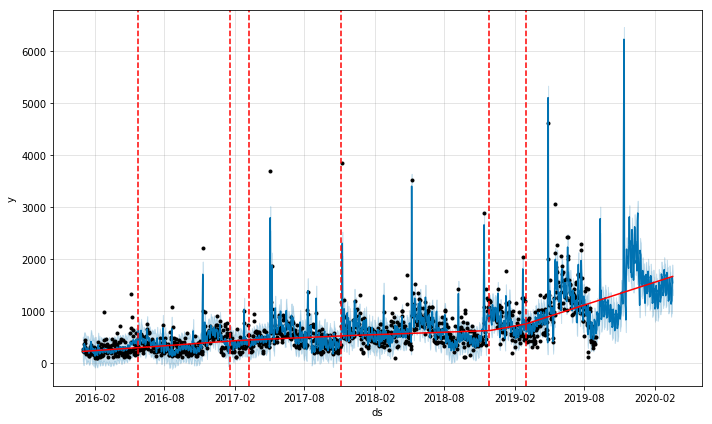

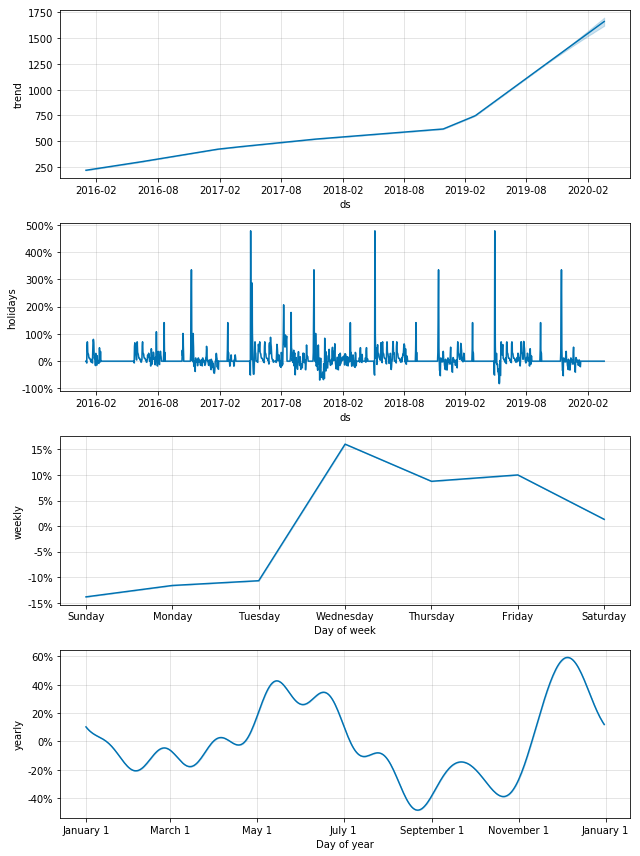

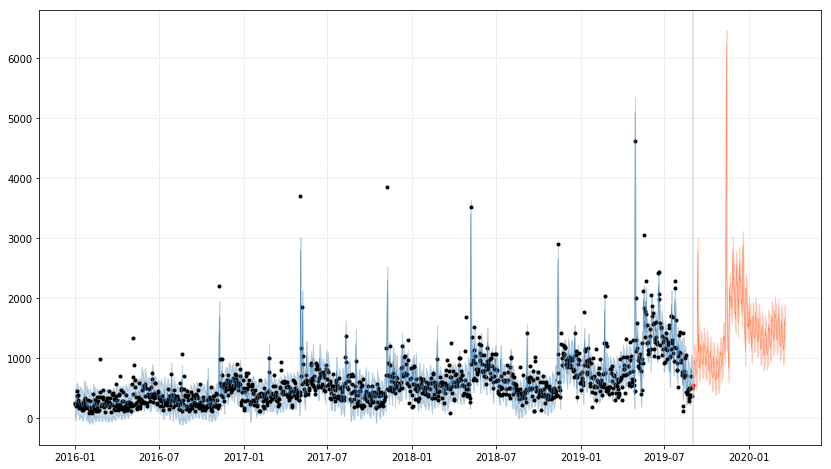

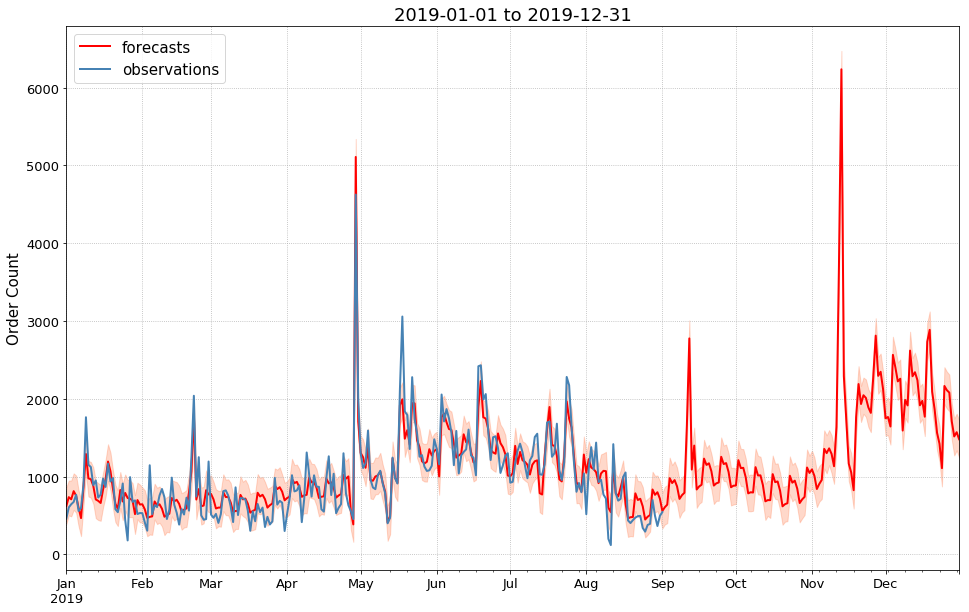

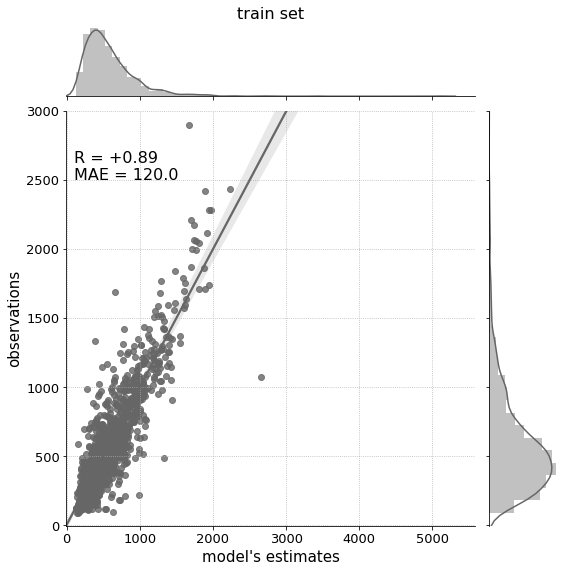

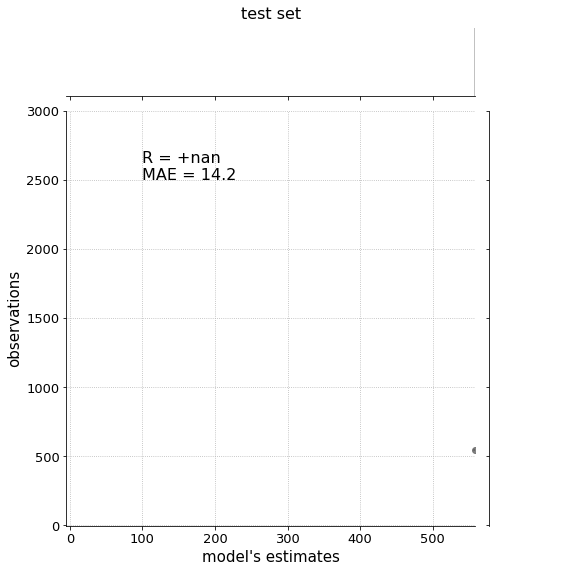

In [18]:
## Validation
fig = co_m.plot(co_forecast)
a = add_changepoints_to_plot(fig.gca(), co_m, co_forecast)


f = co_m.plot_components(co_forecast)


co_verif = utils.make_verif(co_forecast, co_dat_train, co_dat_test)
f = utils.plot_verif(co_verif,date=split_date)


f, ax = plt.subplots(nrows=1, figsize=(16,10), sharey=True)
utils.make_plot_block(co_verif, '2019-01-01', '2019-12-31', ax=ax)


utils.plot_joint_plot(co_verif.loc[co_verif.index<split_date,:], title='train set', fname=None)

utils.plot_joint_plot(co_verif.loc[(co_verif.index>=split_date) &(co_verif['y'].notnull()) ,:], \
                      title='test set', fname=None)

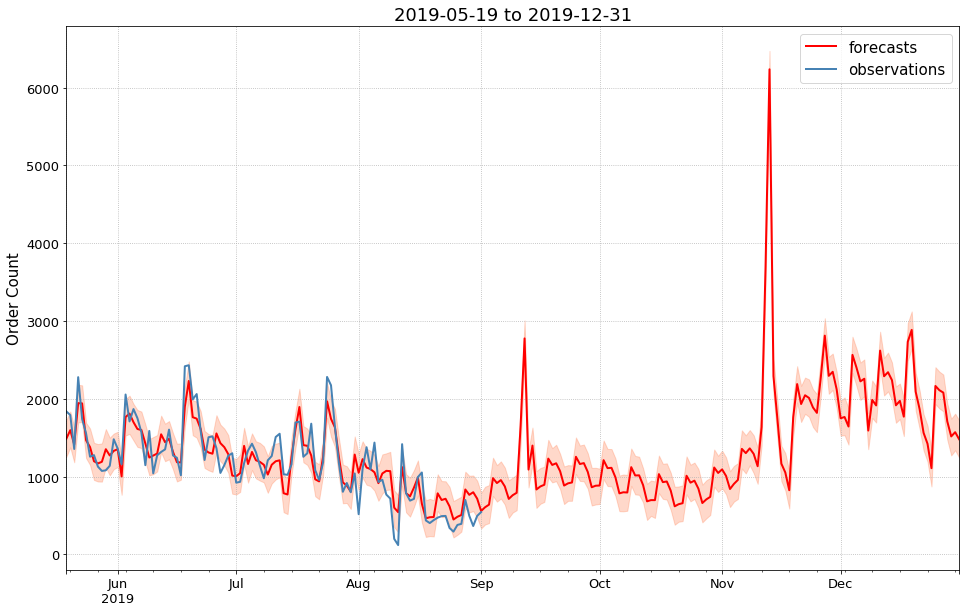

In [19]:
f, ax = plt.subplots(nrows=1, figsize=(16,10), sharey=True)
utils.make_plot_block(co_verif, '2019-05-19', '2019-12-31', ax=ax)

In [20]:
## Cross Validation
df_cv = cross_validation(co_m_full, initial='1210 days', period='7 days', horizon = '14 days')
df_cv_two_week = cross_validation(co_m_full, initial='1210 days', period='1 days', horizon = '14 days')

INFO:fbprophet:Making 17 forecasts with cutoffs between 2019-04-28 00:00:00 and 2019-08-18 00:00:00
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).typ

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [21]:
df_cv['horizon'] = df_cv['ds']  - df_cv['cutoff']
df_cv['mape'] = np.abs(df_cv['yhat'] - df_cv['y'])/ df_cv['y']
df_cv = df_cv.loc[df_cv.mape<1,:]
df_p = performance_metrics(df_cv, rolling_window=0.1)
df_p.head()

horizon            mse        rmse         mae      mape  coverage
0  2 days  179461.915402  423.629455  333.857905  0.284684  0.473389
1  3 days  137738.107736  371.130850  320.518550  0.256924  0.268908
2  4 days  152473.452786  390.478492  336.206214  0.275393  0.300595
3  5 days  148840.065175  385.797959  291.439623  0.213690  0.530612
4  6 days  302356.056151  549.869126  346.433238  0.224155  0.600000

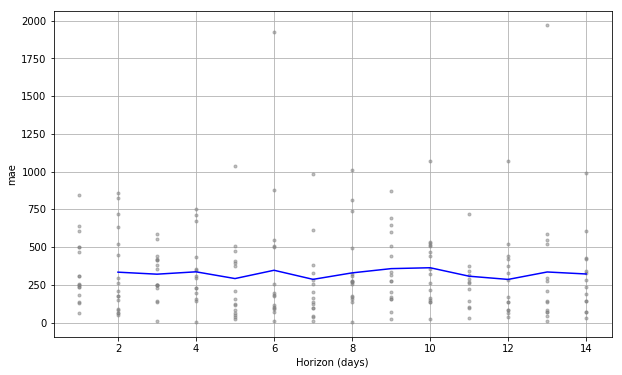

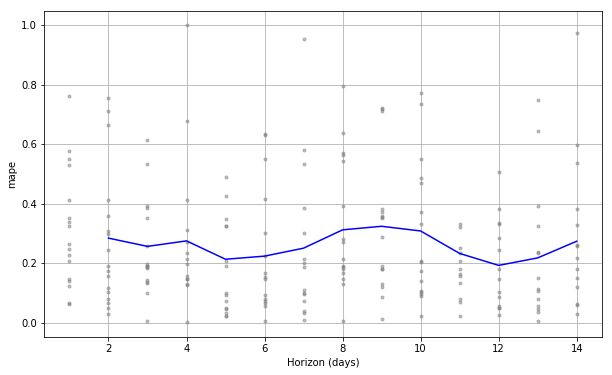

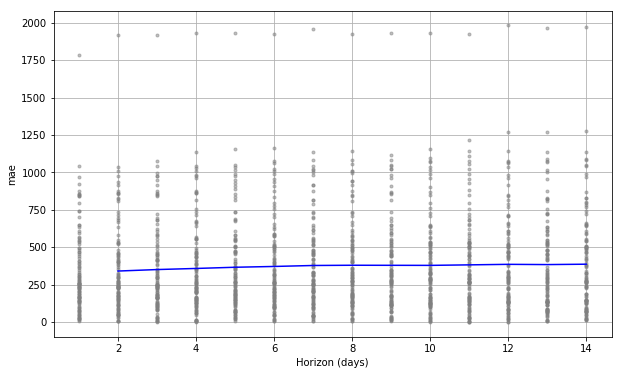

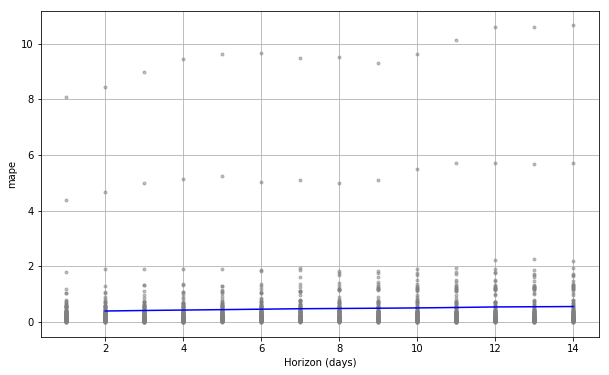

In [22]:
fig = plot_cross_validation_metric(df_cv, metric='mae')
fig = plot_cross_validation_metric(df_cv, metric='mape')
fig = plot_cross_validation_metric(df_cv_two_week, metric='mae')
fig = plot_cross_validation_metric(df_cv_two_week, metric='mape')

In [23]:
df_cv_two_week['horizon'] = df_cv_two_week['ds']  - df_cv_two_week['cutoff']
df_two_week_prediction = df_cv_two_week.loc[df_cv_two_week.horizon=='14 days',:]
df_two_week_prediction.index = df_two_week_prediction.ds
df_two_week_prediction.drop(columns="ds", inplace=True)

df_1_day_prediction = df_cv_two_week.loc[df_cv_two_week.horizon=='1 days',:]
df_1_day_prediction.index = df_1_day_prediction["ds"]
df_1_day_prediction.drop(columns="ds", inplace=True)

co_verif_comp = pd.concat([co_dat_curr_prediction, co_verif], axis=1, join='inner').\
filter(items=['yhat_lower','yhat_upper','yhat','y','excel_forecast'])
co_verif_comp = co_verif_comp.loc[co_verif_comp['y'].notnull() ,:]
co_verif_comp.rename(columns ={'y':'Observations' , 'yhat':f'Prophet Model up until {split_date}', 'excel_forecast':'Current Excel Model'} ,inplace=True)

co_verif_comp = co_verif_comp.merge(right = df_two_week_prediction, on="ds" ,how = "inner", suffixes=('',"_2w"))
co_verif_comp.rename(columns ={'yhat':'Prophet Model Two Weeks Ahead'} ,inplace=True)

co_verif_comp.head()

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


yhat_lower   yhat_upper  Prophet Model up until 2019-09-01  \
ds                                                                        
2019-05-19  1253.676267  1728.226471                        1486.856282   
2019-05-20  1376.460721  1837.628125                        1596.871908   
2019-05-21  1184.297240  1636.874601                        1412.133291   
2019-05-22  1696.034840  2179.866596                        1944.040820   
2019-05-23  1700.307810  2172.508281                        1940.999151   

            Observations  Current Excel Model  Prophet Model Two Weeks Ahead  \
ds                                                                             
2019-05-19        1838.0              2144.79                     849.852648   
2019-05-20        1791.0              1884.79                     750.521730   
2019-05-21        1355.0              2088.79                     843.553387   
2019-05-22        2278.0              1868.79                    1185.981397   
2019-05-23        1740.0              1696.51                    1451.318592   

            yhat_lower_2w  yhat_upper_2w     y     cutoff horizon  
ds                                                                 
2019-05-19     643.473738    1065.651522  1838 2019-05-05 14 days  
2019-05-20     541.063546     974.495309  1791 2019-05-06 14 days  
2019-05-21     630.273417    1056.952159  1355 2019-05-07 14 days  
2019-05-22     969.591964    1397.523808  2278 2019-05-08 14 days  
2019-05-23    1232.930264    1666.636553  1740 2019-05-09 14 days

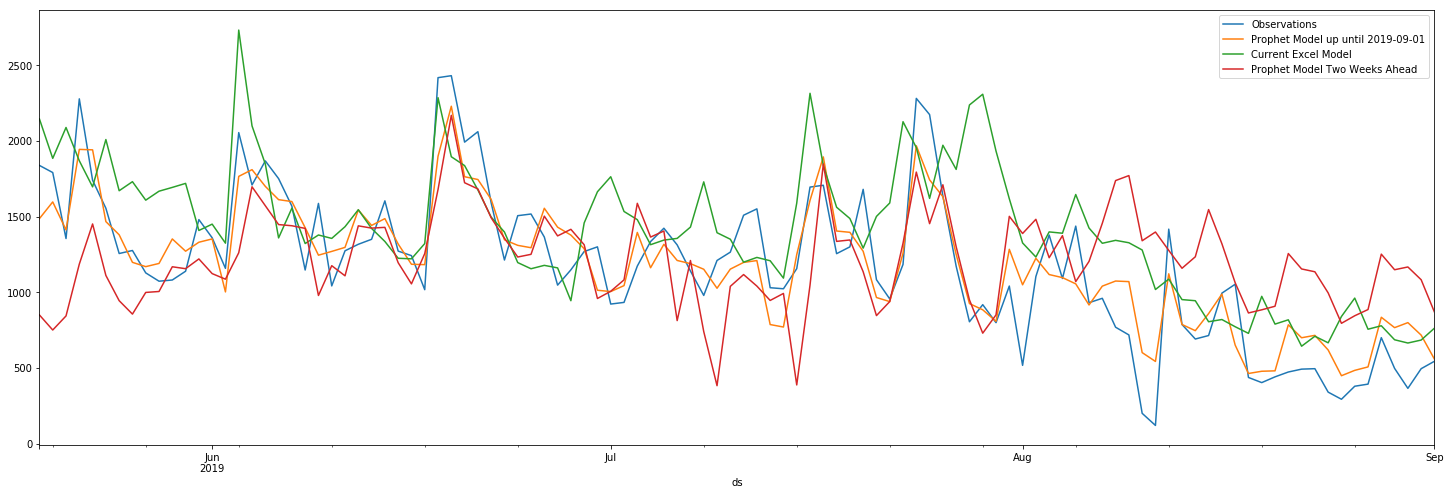

In [24]:
_, ax = plt.subplots(figsize=(25,8))
co_verif_comp.loc[:,['Observations',f'Prophet Model up until {split_date}'\
                  ,'Current Excel Model','Prophet Model Two Weeks Ahead']].plot(ax=ax)
# ax.fill_between(verif_comp.index, verif_comp.loc[:,'yhat_lower'], verif_comp.loc[:,'yhat_upper'], color='coral', alpha=0.3)


In [25]:
print('MAPE of the Current Model ' + str(np.mean(np.abs(co_verif_comp['Current Excel Model'] - co_verif_comp['Observations'])/co_verif_comp['Observations'])))
print(f'MAPE of the Prophet Model Up Until {split_date}  ' + str(np.mean(np.abs(co_verif_comp[f'Prophet Model up until {split_date}'] - co_verif_comp['Observations'])/co_verif_comp['Observations'])))
print(f'MAPE of the Prophet Model Two Weeks Prediction  ' + str(np.mean(np.abs(co_verif_comp['Prophet Model Two Weeks Ahead'] - co_verif_comp['Observations'])/co_verif_comp['Observations'])))


MAPE of the Current Model 0.49701546976660216
MAPE of the Prophet Model Up Until 2019-09-01  0.22691292437299576
MAPE of the Prophet Model Two Weeks Prediction  0.5642385623981772


In [26]:
# First (Incorrect 7/23)
# MAPE of the Current Model 0.2356932773388679
# MAPE of the Prophet Model Up Until 2019-05-19  0.17342342484494647
# MAPE of the Prophet Model Two Weeks Prediction  0.16988295234710005

# Second (Corrected 7/24)
# MAPE of the Current Model 0.2356932773388679
# MAPE of the Prophet Model Up Until 2019-05-19  0.17199888077987097
# MAPE of the Prophet Model Two Weeks Prediction  0.1686462523082831

# Third (w/ Employee)
# MAPE of the Current Model 0.2356932773388679
# MAPE of the Prophet Model Up Until 2019-05-19  0.17404171412011635
# MAPE of the Prophet Model Two Weeks Prediction  0.17068368655718888

In [27]:
(np.abs(co_verif_comp['Prophet Model Two Weeks Ahead'].replace(0, np.nan) - co_verif_comp['Observations'].replace(0, np.nan))/co_verif_comp['Observations'].replace(0, np.nan)).sort_values(ascending=False)

ds
2019-08-11    10.650204
2019-08-10     5.701241
2019-08-30     2.197531
2019-08-24     1.928555
2019-08-25     1.712674
2019-08-01     1.685377
2019-08-21     1.654892
2019-08-09     1.466516
2019-08-22     1.345533
2019-08-29     1.311400
2019-08-23     1.293607
2019-08-08     1.260099
2019-08-27     1.254008
2019-08-26     1.228830
2019-08-19     1.193621
2019-08-31     1.187167
2019-08-15     1.165724
2019-08-20     1.057948
2019-08-18     0.975195
2019-08-28     0.788251
2019-08-14     0.786347
2019-07-09     0.683791
2019-07-15     0.664705
2019-09-01     0.597595
2019-05-20     0.580948
2019-05-19     0.537621
2019-08-07     0.516315
2019-05-22     0.479376
2019-08-13     0.472052
2019-07-31     0.442409
                ...    
2019-07-27     0.110137
2019-06-14     0.109198
2019-08-03     0.108720
2019-06-19     0.107708
2019-06-26     0.101034
2019-08-12     0.098969
2019-06-12     0.092532
2019-07-01     0.091633
2019-06-07     0.082535
2019-07-17     0.082343
2019-07-13   

## D. FB Prophet Model - Inbound Purchase Orders

In [28]:
# ADDITONAL REGRESSOR - Purchase Orders Estimated Delivery Windows
po_reg_raw = pd.read_csv('data/PO_EST_ACT_MA.csv')
po_reg_1_full = po_reg_raw[['date','IN_PO_EST']]
po_reg_1_full = po_reg_1_full.rename(columns={'date':'ds','IN_PO_EST':'reg'})

po_reg_1_train = po_reg_1_full[po_reg_1_full['ds']<split_date]

In [29]:
po_reg_1_full.tail()

ds         reg
1489  2020-01-29  439.159390
1490  2020-01-30  441.837962
1491  2020-01-31  368.890628
1492  2020-02-01    0.000000
1493  2020-02-02    0.000000

In [30]:
po_m = Prophet(changepoint_prior_scale=0.1, changepoint_range=0.9 ,\
            seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
            holidays_prior_scale = 10, \
            yearly_seasonality=True, \
            weekly_seasonality=True, \
            daily_seasonality=False \
           ,holidays = po_holidays
           )

po_m_full = Prophet(changepoint_prior_scale=0.1, changepoint_range=0.9 ,\
            seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
            holidays_prior_scale = 10, \
            yearly_seasonality=True, \
            weekly_seasonality=True, \
            daily_seasonality=False \
           ,holidays = po_holidays
           )

# ### Add extra regressors
po_dat_train['reg'] = po_reg_1_train['reg']
po_m.add_regressor('reg', prior_scale = 10, mode='multiplicative') 

po_dat_all['reg'] = po_reg_1_full['reg']
po_m_full.add_regressor('reg', prior_scale = 10, mode='multiplicative') 

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [31]:
# fit the model
po_m.fit(po_dat_train)
po_m_full.fit(po_dat_all)

# predict forward_days 
po_future = po_m.make_future_dataframe(periods=len(po_dat_test)+forward_days, freq='1D')
po_future['reg'] = po_reg_1_full['reg']

po_future = po_future[po_future['ds'] < '2020-01-01']

po_forecast = po_m.predict(po_future)
po_forecast.loc[po_forecast.ds>=split_date,:].head()


# components showing
po_m_full.component_modes

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


{'additive': ['additive_terms', 'extra_regressors_additive'],
 'multiplicative': ['yearly',
  'weekly',
  'PO BULK',
  'reg',
  'multiplicative_terms',
  'extra_regressors_multiplicative',
  'holidays']}

In [32]:
po_verif = utils.make_verif(po_forecast, po_dat_train, po_dat_test)

# if weekend then make it 0
po_verif['weekend'] = ((pd.DatetimeIndex(po_verif.index).dayofweek) // 5 == 1).astype(float)
po_verif.loc[po_verif['weekend'] > 0.0, 'yhat'] = 0

# if negative then make it 0
po_verif.loc[po_verif['yhat'] < 0.0, 'yhat'] = 0

C:\Users\m.young\Documents\GitHub\data-science-modeling-xmen\workforce_prediction\queries\utils.py:182: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([data_train_tmp, data_test_tmp], axis=0)


C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


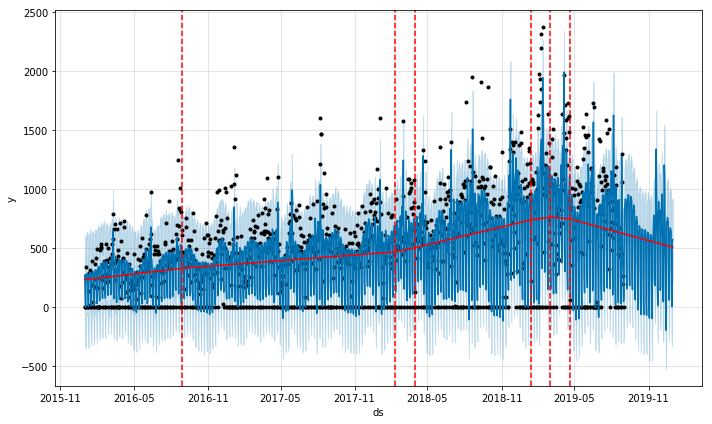

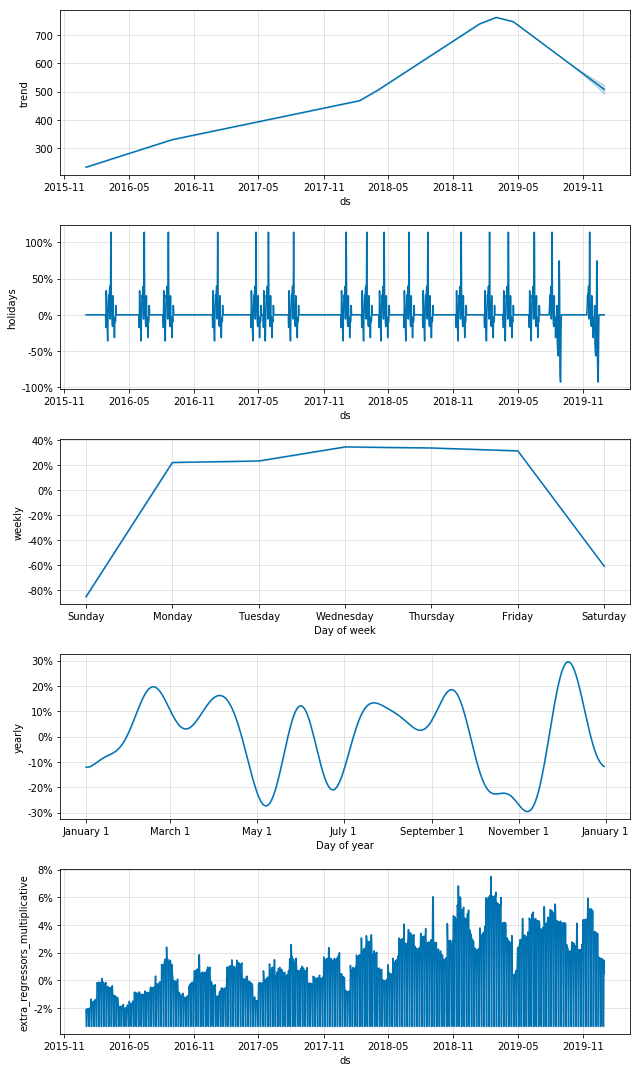

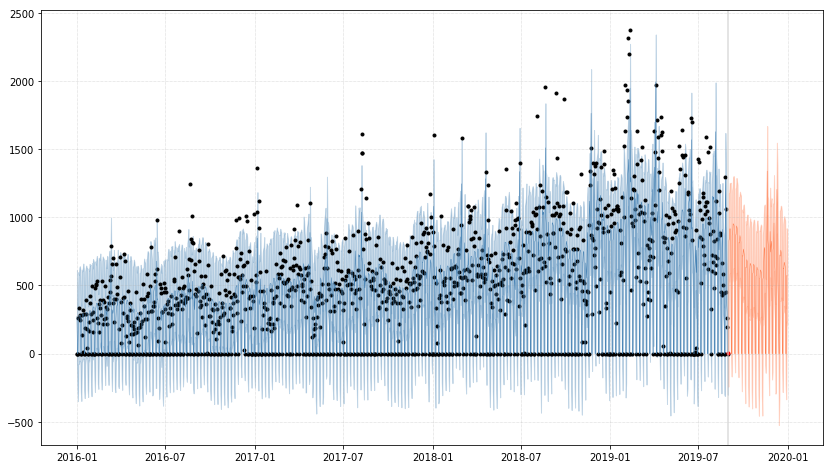

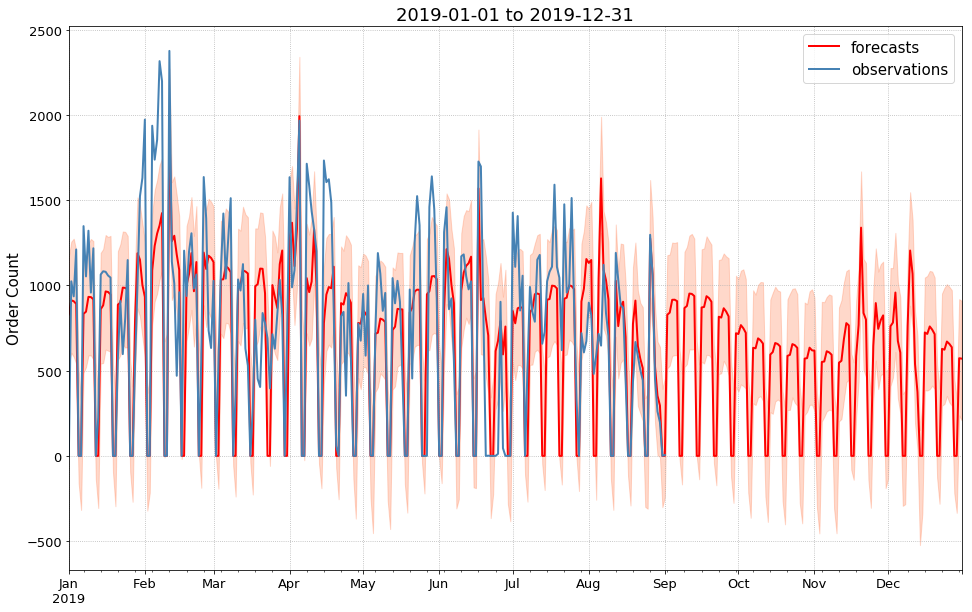

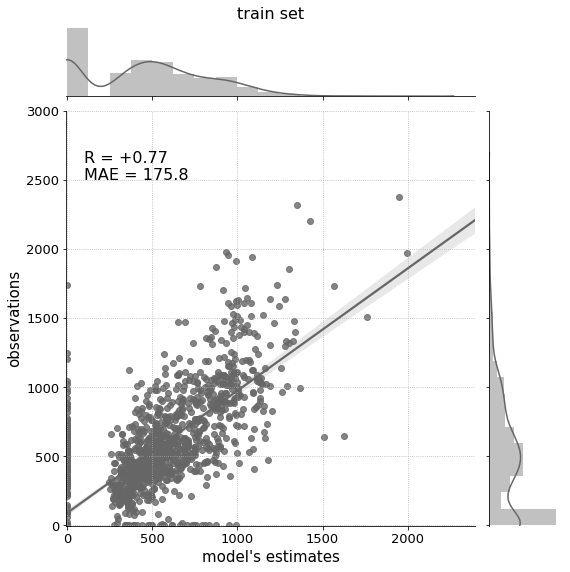

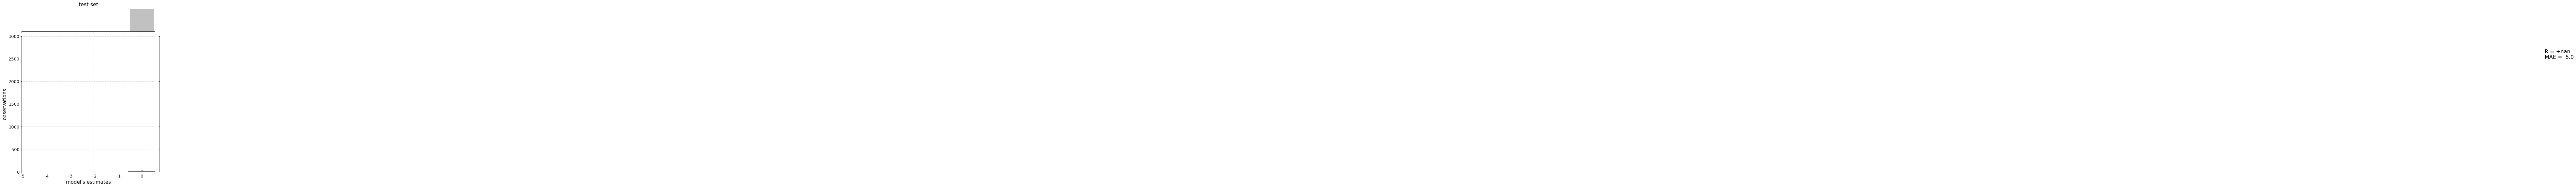

In [33]:
## Validation
fig = po_m.plot(po_forecast)
a = add_changepoints_to_plot(fig.gca(), po_m, po_forecast)

f = po_m.plot_components(po_forecast)

f = utils.plot_verif(po_verif,date=split_date)

f, ax = plt.subplots(nrows=1, figsize=(16,10), sharey=True)
utils.make_plot_block(po_verif, '2019-01-01', '2019-12-31', ax=ax)


utils.plot_joint_plot(po_verif.loc[po_verif.index<split_date,:], title='train set', fname=None)

utils.plot_joint_plot(po_verif.loc[(po_verif.index>=split_date) &(po_verif['y'].notnull()) ,:], \
                      title='test set', fname=None)

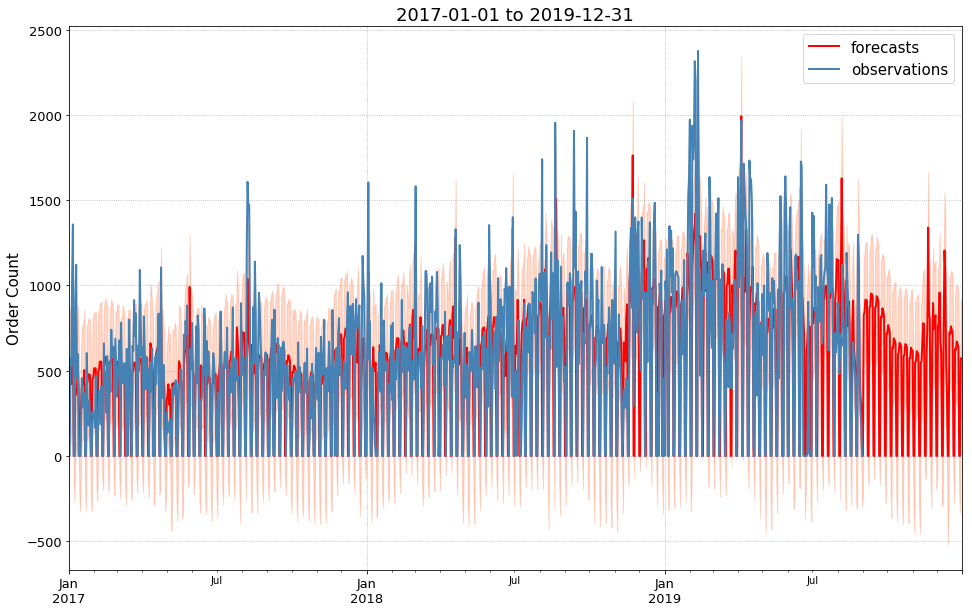

In [34]:
f, ax = plt.subplots(nrows=1, figsize=(16,10), sharey=True)
utils.make_plot_block(po_verif, '2017-01-01', '2019-12-31', ax=ax)


In [35]:
## Cross Validation
df_cv = cross_validation(po_m_full, initial='1210 days', period='7 days', horizon = '14 days')
df_cv_two_week = cross_validation(po_m_full, initial='1210 days', period='1 days', horizon = '14 days')

INFO:fbprophet:Making 17 forecasts with cutoffs between 2019-04-28 00:00:00 and 2019-08-18 00:00:00
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).typ

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [36]:
df_cv['horizon'] = df_cv['ds']  - df_cv['cutoff']
df_cv['mape'] = np.abs(df_cv['yhat'] - df_cv['y'])/ df_cv['y']
df_cv = df_cv.loc[df_cv.mape<1,:]
df_p = performance_metrics(df_cv, rolling_window=0.1)
df_p.head()

horizon            mse        rmse         mae      mape  coverage
0  1 days  105864.567689  325.368357  241.405610  0.229667  0.642857
1  2 days   90992.903649  301.650300  245.319007  0.221284  0.688776
2  3 days  103781.527135  322.151404  265.598579  0.270952  0.625000
3  4 days  122331.539360  349.759259  294.336737  0.316733  0.600000
4  5 days  130458.760326  361.190753  305.009315  0.357355  0.657143

In [37]:
df_cv_two_week['horizon'] = df_cv_two_week['ds']  - df_cv_two_week['cutoff']
df_two_week_prediction = df_cv_two_week.loc[df_cv_two_week.horizon=='14 days',:]
df_two_week_prediction.index = df_two_week_prediction.ds
df_two_week_prediction.drop(columns="ds", inplace=True)

df_1_day_prediction = df_cv_two_week.loc[df_cv_two_week.horizon=='1 days',:]
df_1_day_prediction.index = df_1_day_prediction["ds"]
df_1_day_prediction.drop(columns="ds", inplace=True)

po_verif_comp = pd.concat([po_dat_curr_prediction, po_verif], axis=1, join='inner').\
filter(items=['yhat_lower','yhat_upper','yhat','y','excel_forecast'])
po_verif_comp = po_verif_comp.loc[po_verif_comp['y'].notnull() ,:]
po_verif_comp.rename(columns ={'y':'Observations' , 'yhat':f'Prophet Model up until {split_date}', 'excel_forecast':'Current Excel Model'} ,inplace=True)

po_verif_comp = po_verif_comp.merge(right = df_two_week_prediction, on="ds" ,how = "inner", suffixes=('',"_2w"))
po_verif_comp.rename(columns ={'yhat':'Prophet Model Two Weeks Ahead'} ,inplace=True)


# if weekend then make it 0
po_verif_comp['weekend'] = ((pd.DatetimeIndex(po_verif_comp.index).dayofweek) // 5 == 1).astype(float)
po_verif_comp.loc[po_verif_comp['weekend'] > 0.0, 'Prophet Model Two Weeks Ahead'] = 0
po_verif_comp.loc[po_verif_comp['weekend'] > 0.0, f'Prophet Model up until {split_date}'] = 0

# if negative then make it 0
po_verif_comp.loc[po_verif_comp['Prophet Model Two Weeks Ahead'] < 0.0, 'Prophet Model Two Weeks Ahead'] = 0
po_verif_comp.loc[po_verif_comp[f'Prophet Model up until {split_date}'] < 0.0, f'Prophet Model up until {split_date}'] = 0

po_verif_comp.head()

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


yhat_lower   yhat_upper  Prophet Model up until 2019-09-01  \
ds                                                                       
2019-05-19 -332.980497   345.529757                           0.000000   
2019-05-20  538.625855  1176.162859                         841.836733   
2019-05-21  552.564277  1226.350386                         868.422016   
2019-05-22  639.602327  1290.541228                         964.962175   
2019-05-23  650.952700  1305.259751                         975.323354   

            Observations  Current Excel Model  Prophet Model Two Weeks Ahead  \
ds                                                                             
2019-05-19           0.0                 0.00                       0.000000   
2019-05-20         976.0              1039.73                     924.705091   
2019-05-21         454.0               586.73                     977.756712   
2019-05-22        1253.0               506.73                    1102.912735   
2019-05-23        1524.0               619.73                    1092.179877   

            yhat_lower_2w  yhat_upper_2w       y     cutoff horizon  weekend  
ds                                                                            
2019-05-19    -359.600446     274.089339     0.0 2019-05-05 14 days      1.0  
2019-05-20     612.571239    1209.645708   976.0 2019-05-06 14 days      0.0  
2019-05-21     643.022533    1289.975504   454.0 2019-05-07 14 days      0.0  
2019-05-22     778.015948    1409.068117  1253.0 2019-05-08 14 days      0.0  
2019-05-23     792.039074    1424.312386  1524.0 2019-05-09 14 days      0.0

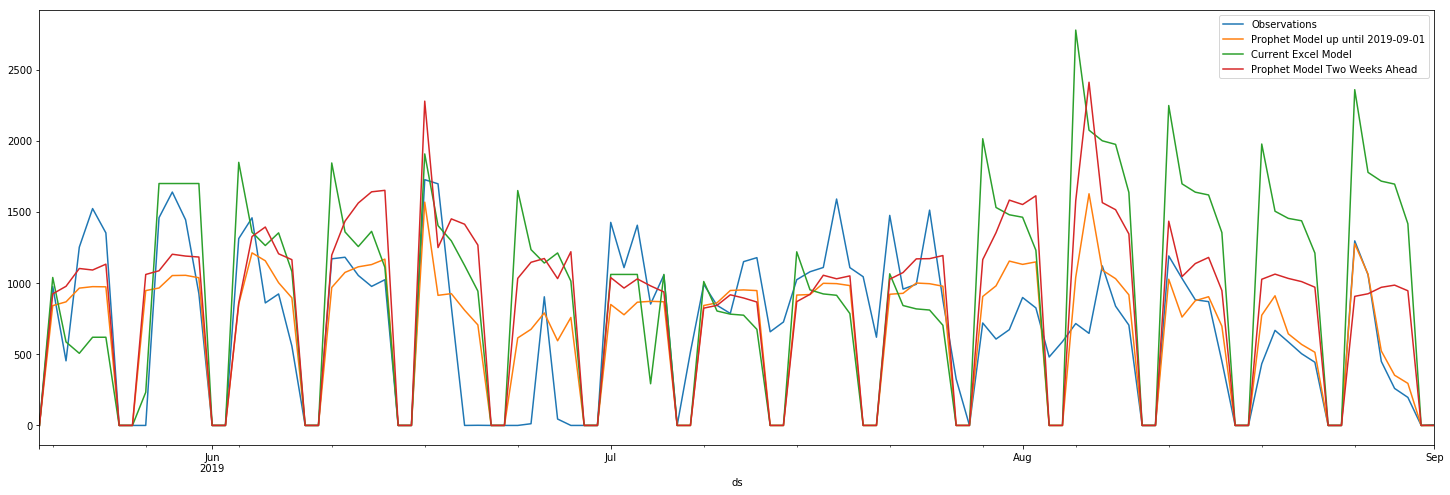

In [38]:
_, ax = plt.subplots(figsize=(25,8))
po_verif_comp.loc[:,['Observations',f'Prophet Model up until {split_date}'\
                  ,'Current Excel Model','Prophet Model Two Weeks Ahead']].plot(ax=ax)
# ax.fill_between(verif_comp.index, verif_comp.loc[:,'yhat_lower'], verif_comp.loc[:,'yhat_upper'], color='coral', alpha=0.3)


In [39]:
print('MAPE of the Current Model ' + str(np.mean(np.abs(po_verif_comp['Current Excel Model'].replace(0, np.nan) - po_verif_comp['Observations'].replace(0, np.nan))/po_verif_comp['Observations'].replace(0, np.nan))))
print(f'MAPE of the Prophet Model Up Until {split_date}  ' + str(np.mean(np.abs(po_verif_comp[f'Prophet Model up until {split_date}'].replace(0, np.nan) - po_verif_comp['Observations'].replace(0, np.nan))/po_verif_comp['Observations'].replace(0, np.nan))))
print(f'MAPE of the Prophet Model Two Weeks Prediction  ' + str(np.mean(np.abs(po_verif_comp['Prophet Model Two Weeks Ahead'].replace(0, np.nan) - po_verif_comp['Observations'].replace(0, np.nan))/po_verif_comp['Observations'].replace(0, np.nan))))


MAPE of the Current Model 15.898051296019897
MAPE of the Prophet Model Up Until 2019-09-01  11.140284723615974
MAPE of the Prophet Model Two Weeks Prediction  20.018860923783045


In [40]:
# MAPE of the Current Model 21.34107788721027
# MAPE of the Prophet Model Up Until 2019-05-19  26.943743728224433
# MAPE of the Prophet Model Two Weeks Prediction  25.942597891870182

In [41]:
print('MAPE of the Current Model ' + str(np.mean(np.abs(po_verif_comp['Current Excel Model'].replace(0, np.nan) - po_verif_comp['Observations'].replace(0, np.nan)))))

MAPE of the Current Model 598.7967605633805


In [42]:
# CHECK FOR OUTLIERS SKEWING MAPE RESULTS
(np.abs(po_verif_comp['Prophet Model Two Weeks Ahead'].replace(0, np.nan) - po_verif_comp['Observations'].replace(0, np.nan))/po_verif_comp['Observations'].replace(0, np.nan)).sort_values(ascending=False)

ds
2019-06-21    1266.366063
2019-06-25      94.539307
2019-06-27      21.928326
2019-08-30       3.803843
2019-08-29       2.792115
2019-08-06       2.727659
2019-08-19       1.372106
2019-07-31       1.352783
2019-07-30       1.231535
2019-08-05       1.205168
2019-08-23       1.187933
2019-08-28       1.157085
2019-05-21       1.153649
2019-08-16       1.101634
2019-06-07       1.087626
2019-08-22       1.005369
2019-08-02       0.953873
2019-08-09       0.908696
2019-08-08       0.809140
2019-08-21       0.759940
2019-06-19       0.734308
2019-08-01       0.726926
2019-06-13       0.680341
2019-06-05       0.619373
2019-07-29       0.618464
2019-06-14       0.613392
2019-08-20       0.591710
2019-06-12       0.483018
2019-08-07       0.396727
2019-08-15       0.357075
                 ...     
2019-06-02            NaN
2019-06-08            NaN
2019-06-09            NaN
2019-06-15            NaN
2019-06-16            NaN
2019-06-20            NaN
2019-06-22            NaN
2019-06-2

In [43]:
# REMOVE TOP 3 OUTLIERS SKEWING MAPE RESULTS
adj_po_verif_comp = po_verif_comp[~po_verif_comp.index.isin(['2019-06-21','2019-06-25','2019-06-27'])]

In [44]:
# RECALCULATE MAPE RESULTS w/o OUTLIERS
print('MAPE of the Current Model ' + str(np.mean(np.abs(adj_po_verif_comp['Current Excel Model'].replace(0, np.nan) - adj_po_verif_comp['Observations'].replace(0, np.nan))/adj_po_verif_comp['Observations'].replace(0, np.nan))))
print(f'MAPE of the Prophet Model Up Until {split_date}  ' + str(np.mean(np.abs(adj_po_verif_comp[f'Prophet Model up until {split_date}'].replace(0, np.nan) - adj_po_verif_comp['Observations'].replace(0, np.nan))/adj_po_verif_comp['Observations'].replace(0, np.nan))))
print(f'MAPE of the Prophet Model Two Weeks Prediction  ' + str(np.mean(np.abs(adj_po_verif_comp['Prophet Model Two Weeks Ahead'].replace(0, np.nan) - adj_po_verif_comp['Observations'].replace(0, np.nan))/adj_po_verif_comp['Observations'].replace(0, np.nan))))


MAPE of the Current Model 0.8523395067920213
MAPE of the Prophet Model Up Until 2019-09-01  0.2653962385194843
MAPE of the Prophet Model Two Weeks Prediction  0.5662563090037798


## E. FB Prophet Model - Inbound Customer Returns

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


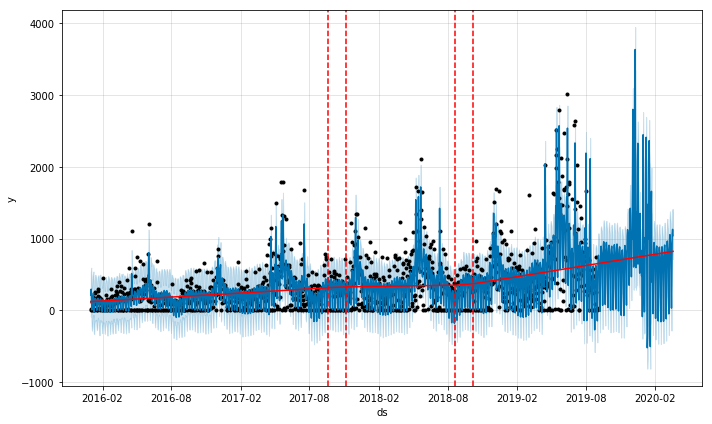

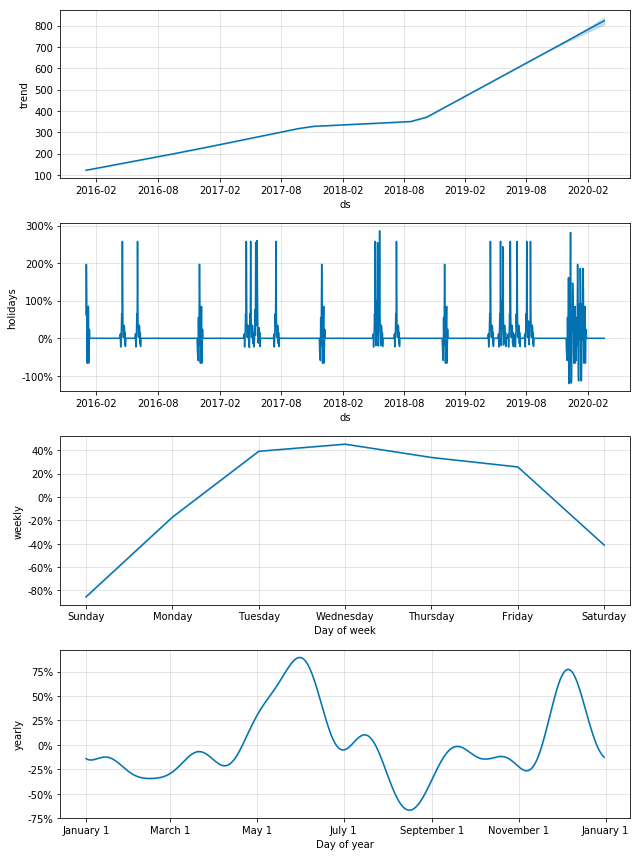

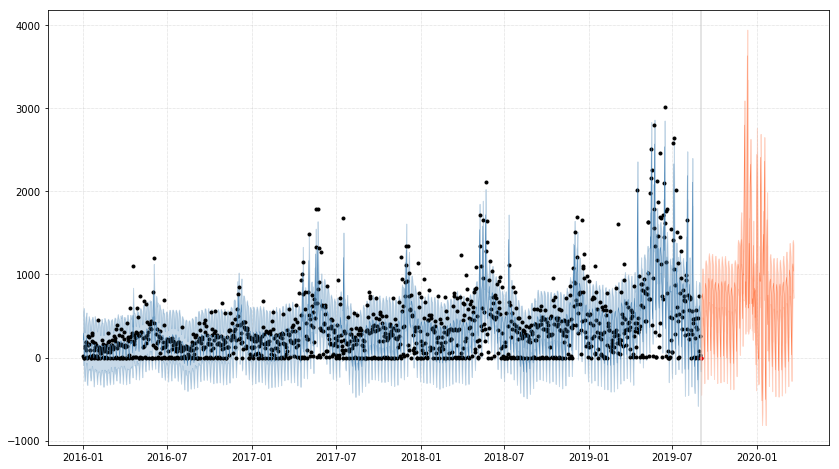

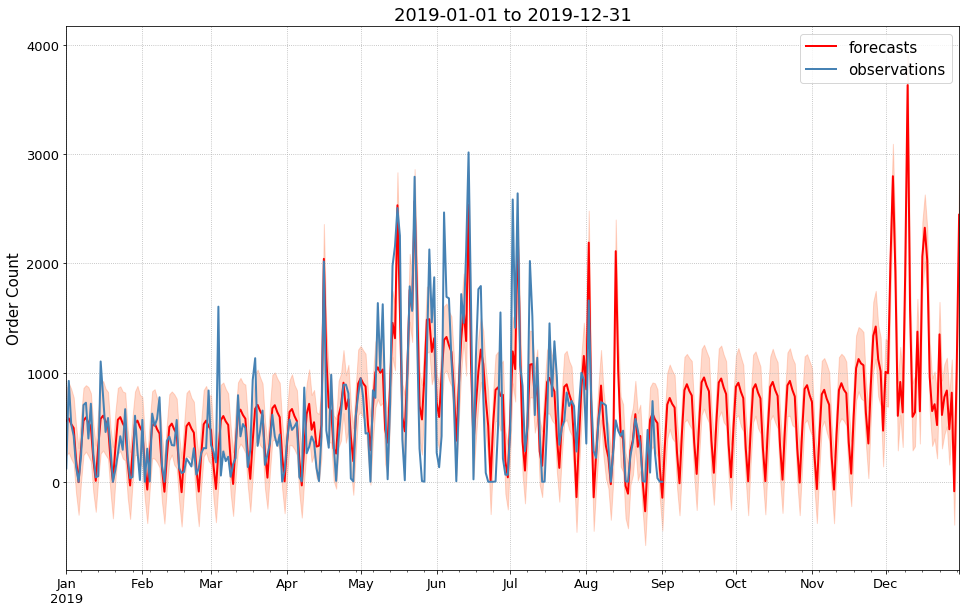

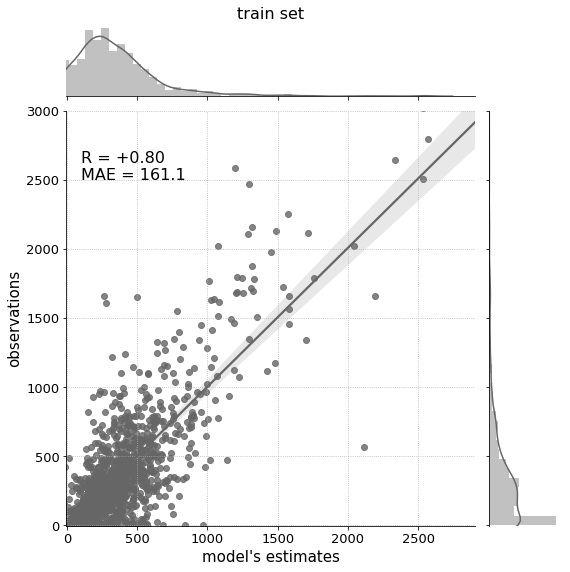

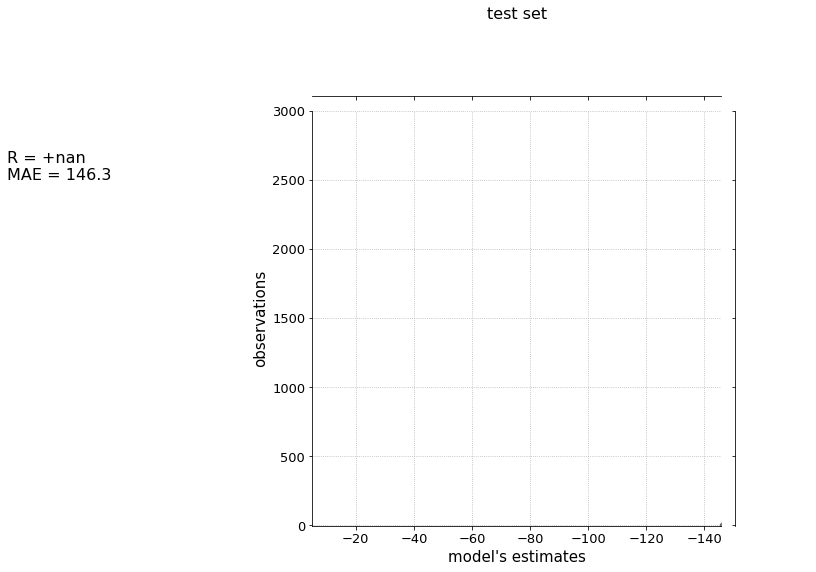

In [45]:
cr_m = Prophet(changepoint_prior_scale=0.1, changepoint_range=0.9 ,\
            seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
            holidays_prior_scale = 10, \
            yearly_seasonality=True, \
            weekly_seasonality=True, \
            daily_seasonality=False \
            ,holidays = cr_holidays
            
           )

cr_m_full = Prophet(changepoint_prior_scale=0.1, changepoint_range=0.9 ,\
            seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
            holidays_prior_scale = 10, \
            yearly_seasonality=True, \
            weekly_seasonality=True, \
            daily_seasonality=False \
            ,holidays = cr_holidays
           )

# fit the model
cr_m.fit(cr_dat_train)
cr_m_full.fit(cr_dat_all)

# predict forward_days 
cr_future = cr_m.make_future_dataframe(periods=len(cr_dat_test)+forward_days, freq='1D')

# test no weekends - No effect
# cr_future = cr_future[pd.DatetimeIndex(cr_future['ds']).dayofweek // 5 != 1]

cr_forecast = cr_m.predict(cr_future)
cr_forecast.loc[cr_forecast.ds>=split_date,:].head()

# components showing
cr_m_full.component_modes

## Validation
fig = cr_m.plot(cr_forecast)
a = add_changepoints_to_plot(fig.gca(), cr_m, cr_forecast)


f = cr_m.plot_components(cr_forecast)


cr_verif = utils.make_verif(cr_forecast, cr_dat_train, cr_dat_test)
f = utils.plot_verif(cr_verif,date=split_date)


f, ax = plt.subplots(nrows=1, figsize=(16,10), sharey=True)
utils.make_plot_block(cr_verif, '2019-01-01', '2019-12-31', ax=ax)


utils.plot_joint_plot(cr_verif.loc[cr_verif.index<split_date,:], title='train set', fname=None)

utils.plot_joint_plot(cr_verif.loc[(cr_verif.index>=split_date) &(cr_verif['y'].notnull()) ,:], \
                      title='test set', fname=None)


In [46]:
## Cross Validation
df_cv = cross_validation(cr_m_full, initial='1210 days', period='7 days', horizon = '14 days')
df_cv_two_week = cross_validation(cr_m_full, initial='1210 days', period='1 days', horizon = '14 days')

df_cv['horizon'] = df_cv['ds']  - df_cv['cutoff']
df_cv['mape'] = np.abs(df_cv['yhat'] - df_cv['y'])/ df_cv['y']
df_cv = df_cv.loc[df_cv.mape<1,:]
df_p = performance_metrics(df_cv, rolling_window=0.1)
df_p.head()

df_cv_two_week['horizon'] = df_cv_two_week['ds']  - df_cv_two_week['cutoff']
df_two_week_prediction = df_cv_two_week.loc[df_cv_two_week.horizon=='14 days',:]
df_two_week_prediction.index = df_two_week_prediction.ds
df_two_week_prediction.drop(columns="ds", inplace=True)

df_1_day_prediction = df_cv_two_week.loc[df_cv_two_week.horizon=='1 days',:]
df_1_day_prediction.index = df_1_day_prediction["ds"]
df_1_day_prediction.drop(columns="ds", inplace=True)

INFO:fbprophet:Making 17 forecasts with cutoffs between 2019-04-28 00:00:00 and 2019-08-18 00:00:00
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).typ

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

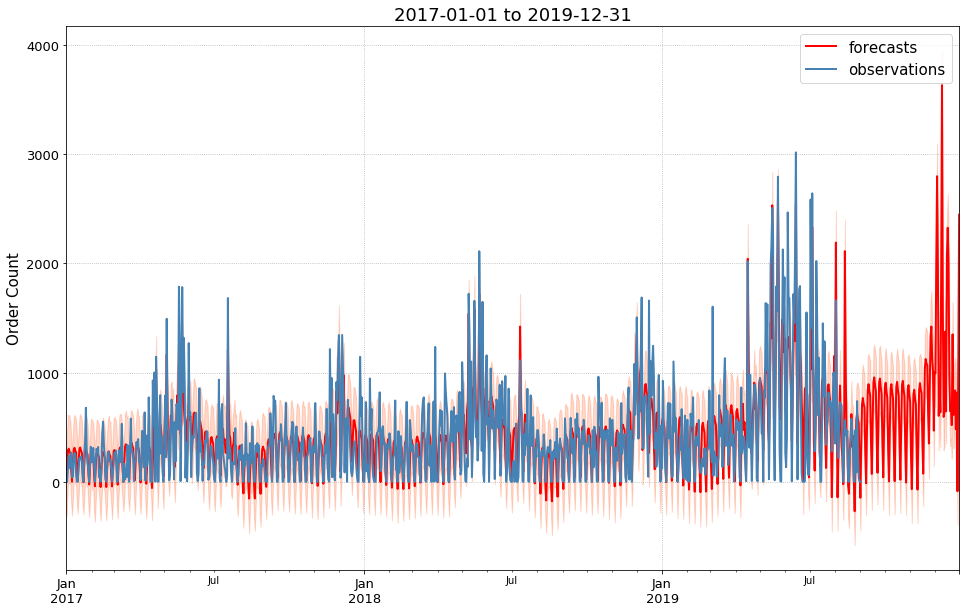

In [47]:
f, ax = plt.subplots(nrows=1, figsize=(16,10), sharey=True)
utils.make_plot_block(cr_verif, '2017-01-01', '2019-12-31', ax=ax)

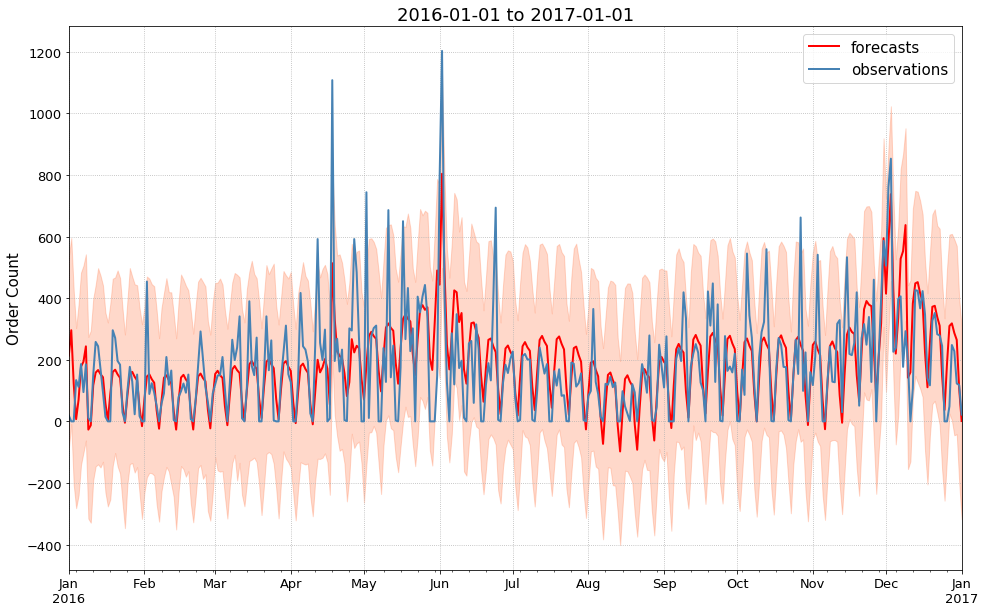

In [48]:
f, ax = plt.subplots(nrows=1, figsize=(16,10), sharey=True)
utils.make_plot_block(cr_verif, '2016-01-01', '2017-01-01', ax=ax)

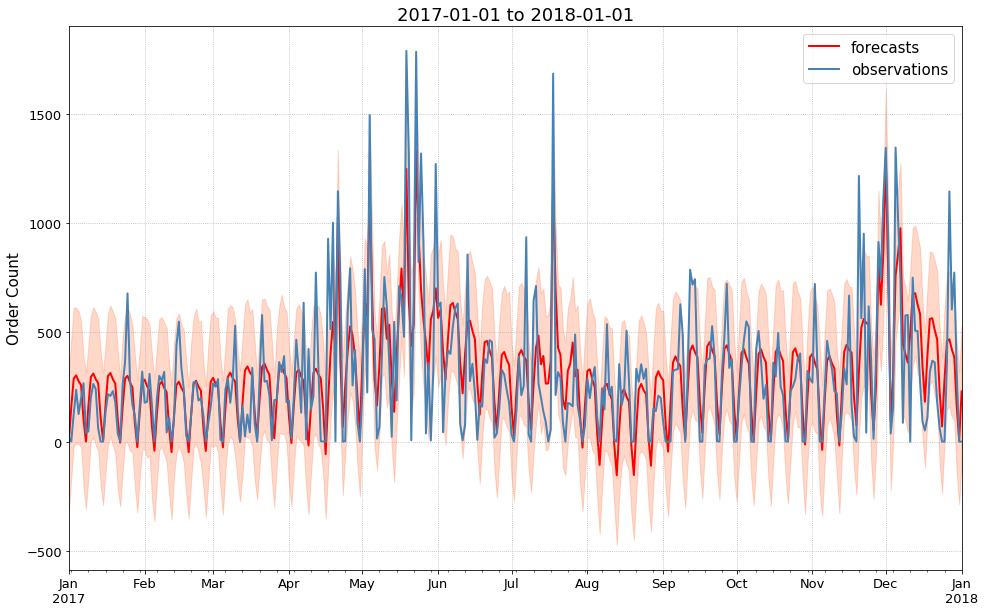

In [49]:
f, ax = plt.subplots(nrows=1, figsize=(16,10), sharey=True)
utils.make_plot_block(cr_verif, '2017-01-01', '2018-01-01', ax=ax)

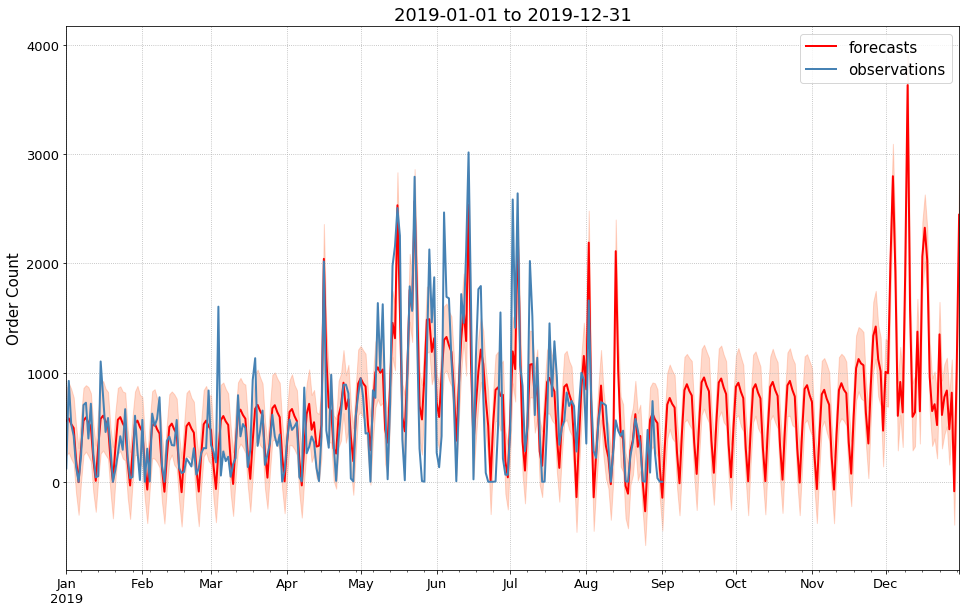

In [50]:
f, ax = plt.subplots(nrows=1, figsize=(16,10), sharey=True)
utils.make_plot_block(cr_verif, '2019-01-01', '2019-12-31', ax=ax)

In [51]:
cr_verif_comp = pd.concat([cr_dat_curr_prediction, cr_verif], axis=1, join='inner').\
filter(items=['yhat_lower','yhat_upper','yhat','y','excel_forecast'])
cr_verif_comp = cr_verif_comp.loc[cr_verif_comp['y'].notnull() ,:]
cr_verif_comp.rename(columns ={'y':'Observations' , 'yhat':f'Prophet Model up until {split_date}', 'excel_forecast':'Current Excel Model'} ,inplace=True)

cr_verif_comp = cr_verif_comp.merge(right = df_two_week_prediction, on="ds" ,how = "inner", suffixes=('',"_2w"))
cr_verif_comp.rename(columns ={'yhat':'Prophet Model Two Weeks Ahead'} ,inplace=True)

# if weekend then make it 0
cr_verif_comp['weekend'] = ((pd.DatetimeIndex(cr_verif_comp.index).dayofweek) // 5 == 1).astype(float)
cr_verif_comp.loc[cr_verif_comp['weekend'] > 0.0, 'Prophet Model Two Weeks Ahead'] = 0
cr_verif_comp.loc[cr_verif_comp['weekend'] > 0.0, f'Prophet Model up until {split_date}'] = 0

# if negative then make it 0
cr_verif_comp.loc[cr_verif_comp['Prophet Model Two Weeks Ahead'] < 0.0, 'Prophet Model Two Weeks Ahead'] = 0
cr_verif_comp.loc[cr_verif_comp[f'Prophet Model up until {split_date}'] < 0.0, f'Prophet Model up until {split_date}'] = 0


MAPE of the Current Model 19.391125177591046
MAPE of the Prophet Model Up Until 2019-09-01  19.4849781525761
MAPE of the Prophet Model Two Weeks Prediction  17.385207962135702


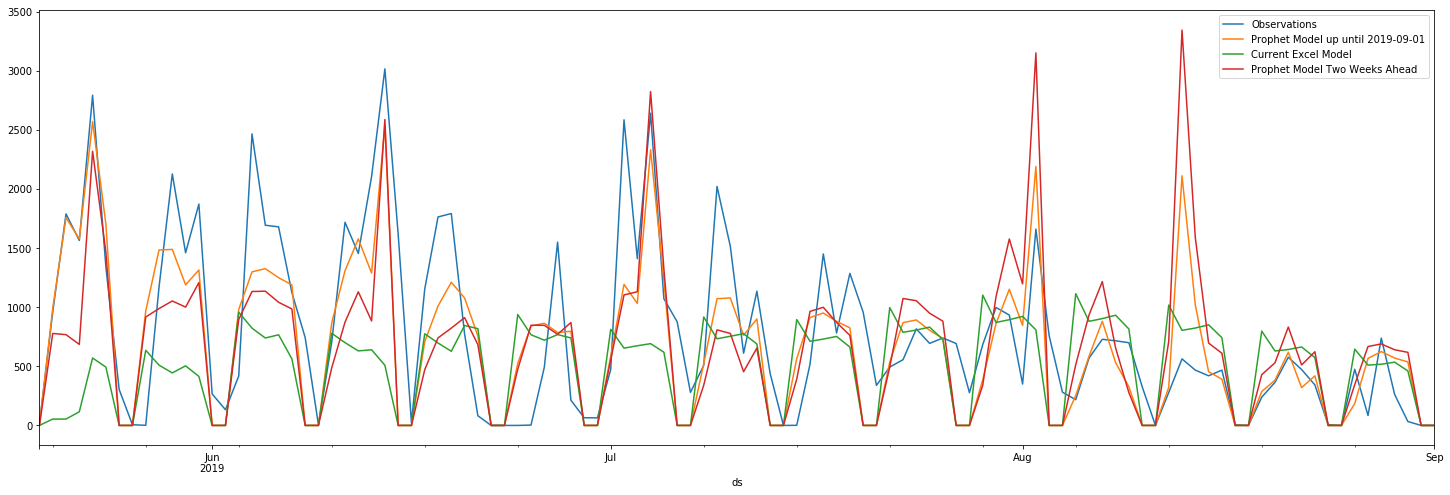

In [52]:
_, ax = plt.subplots(figsize=(25,8))
cr_verif_comp.loc[:,['Observations',f'Prophet Model up until {split_date}'\
                  ,'Current Excel Model','Prophet Model Two Weeks Ahead']].plot(ax=ax)
# ax.fill_between(verif_comp.index, verif_comp.loc[:,'yhat_lower'], verif_comp.loc[:,'yhat_upper'], color='coral', alpha=0.3)


print('MAPE of the Current Model ' + str(np.mean(np.abs(cr_verif_comp['Current Excel Model'] - cr_verif_comp['Observations'])/cr_verif_comp['Observations'].replace(0, np.nan))))
print(f'MAPE of the Prophet Model Up Until {split_date}  ' + str(np.mean(np.abs(cr_verif_comp[f'Prophet Model up until {split_date}'] - cr_verif_comp['Observations'])/cr_verif_comp['Observations'].replace(0, np.nan))))
print(f'MAPE of the Prophet Model Two Weeks Prediction  ' + str(np.mean(np.abs(cr_verif_comp['Prophet Model Two Weeks Ahead'] - cr_verif_comp['Observations'])/cr_verif_comp['Observations'].replace(0, np.nan))))


In [53]:
# CHECK FOR OUTLIERS SKEWING MAPE RESULTS
(np.abs(cr_verif_comp['Prophet Model Two Weeks Ahead'].replace(0, np.nan) - cr_verif_comp['Observations'].replace(0, np.nan))/cr_verif_comp['Observations'].replace(0, np.nan)).sort_values(ascending=False)

ds
2019-05-27    916.298085
2019-07-15    391.154716
2019-06-25    281.527775
2019-08-30     17.740727
2019-06-21      7.332714
2019-08-27      6.951207
2019-08-13      4.941526
2019-06-28      3.068046
2019-08-01      2.421746
2019-08-14      2.396356
2019-08-12      1.545582
2019-08-29      1.434762
2019-08-05      1.358242
2019-06-03      1.145090
2019-07-23      0.931781
2019-08-02      0.897603
2019-07-16      0.859277
2019-08-23      0.817364
2019-08-19      0.796345
2019-06-26      0.721648
2019-07-31      0.688947
2019-08-07      0.669150
2019-08-15      0.659163
2019-08-06      0.639245
2019-08-09      0.603858
2019-07-09      0.600077
2019-06-17      0.591267
2019-06-13      0.580335
2019-06-18      0.580127
2019-07-02      0.573050
                 ...    
2019-05-26           NaN
2019-06-01           NaN
2019-06-02           NaN
2019-06-08           NaN
2019-06-09           NaN
2019-06-15           NaN
2019-06-16           NaN
2019-06-22           NaN
2019-06-23           N

In [54]:
# REMOVE TOP 3 OUTLIERS SKEWING MAPE RESULTS
adj_cr_verif_comp = cr_verif_comp[~cr_verif_comp.index.isin(['2019-05-27','2019-07-15','2019-06-25'])]

# RECALCULATE MAPE RESULTS w/o OUTLIERS
print('MAPE of the Current Model ' + str(np.mean(np.abs(adj_cr_verif_comp['Current Excel Model'].replace(0, np.nan) - adj_cr_verif_comp['Observations'].replace(0, np.nan))/adj_cr_verif_comp['Observations'].replace(0, np.nan))))
print(f'MAPE of the Prophet Model Up Until {split_date}  ' + str(np.mean(np.abs(adj_cr_verif_comp[f'Prophet Model up until {split_date}'].replace(0, np.nan) - adj_cr_verif_comp['Observations'].replace(0, np.nan))/adj_cr_verif_comp['Observations'].replace(0, np.nan))))
print(f'MAPE of the Prophet Model Two Weeks Prediction  ' + str(np.mean(np.abs(adj_cr_verif_comp['Prophet Model Two Weeks Ahead'].replace(0, np.nan) - adj_cr_verif_comp['Observations'].replace(0, np.nan))/adj_cr_verif_comp['Observations'].replace(0, np.nan))))


MAPE of the Current Model 1.0430395618732078
MAPE of the Prophet Model Up Until 2019-09-01  0.7829848716580143
MAPE of the Prophet Model Two Weeks Prediction  1.047670378301756


## F. FB Prophet Model - Inbound Transfer Orders

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
IN

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

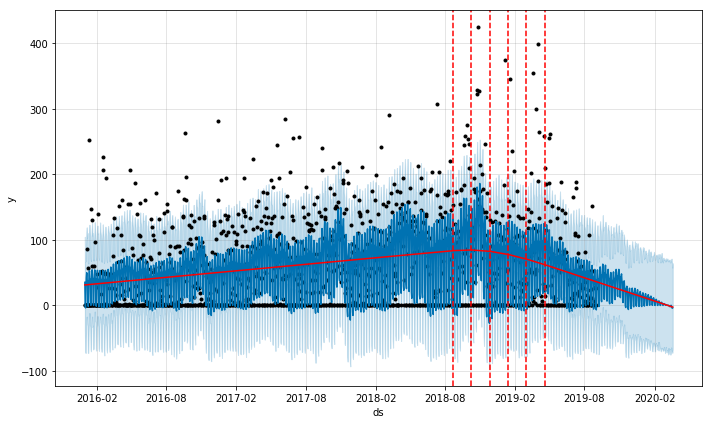

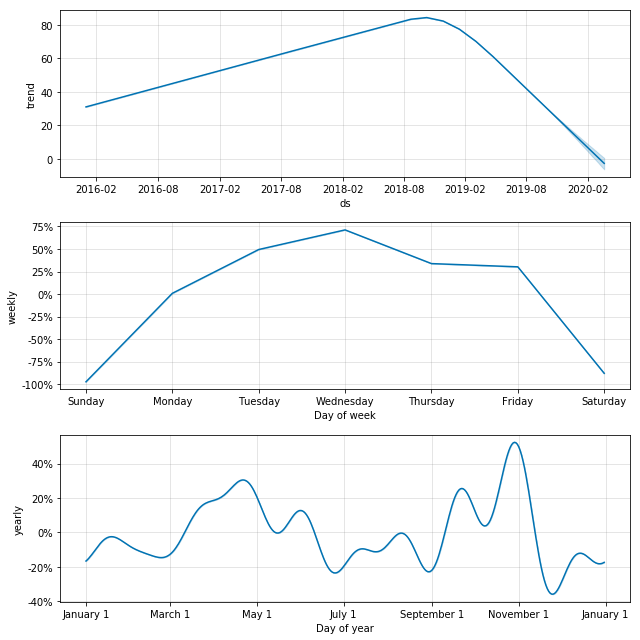

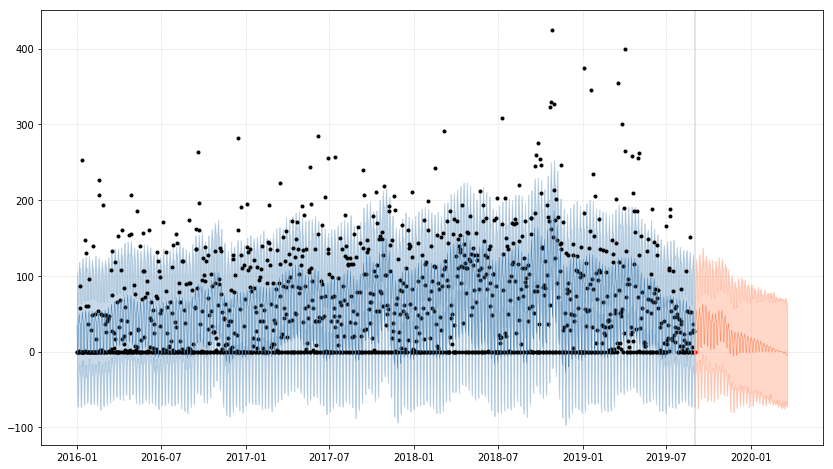

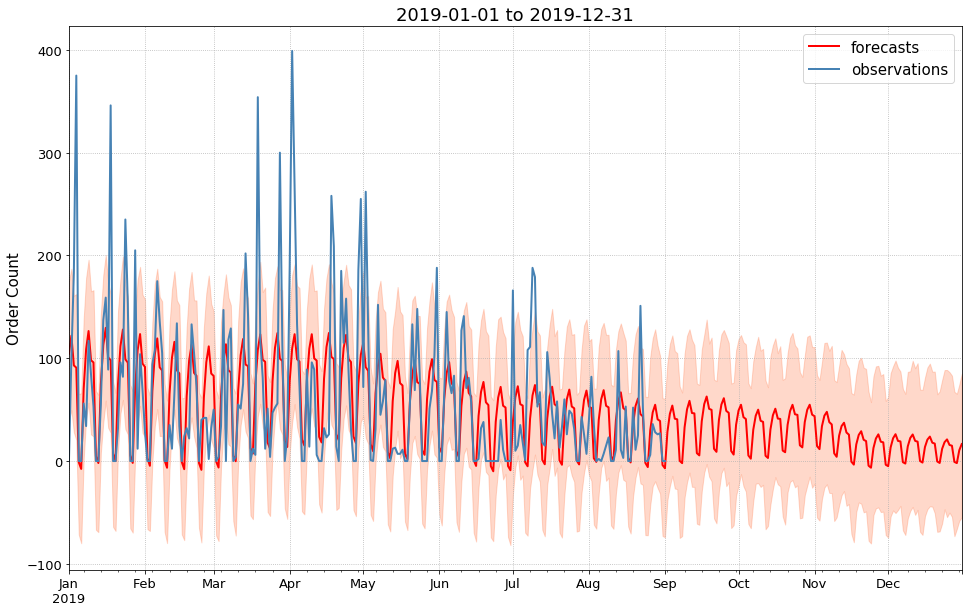

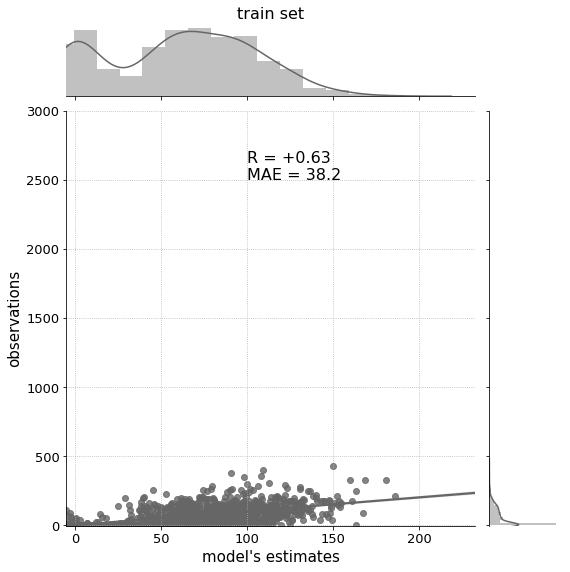

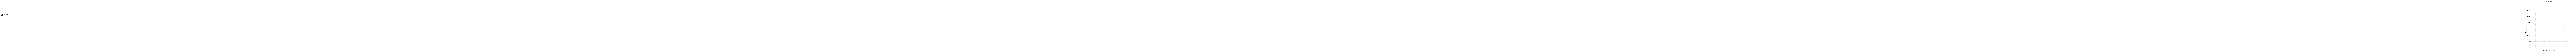

In [55]:
ito_m = Prophet(changepoint_prior_scale=0.1, changepoint_range=0.9 ,\
            seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
            holidays_prior_scale = 10, \
            yearly_seasonality=True, \
            weekly_seasonality=True, \
            daily_seasonality=False \
           #,holidays = ito_holidays
           )

ito_m_full = Prophet(changepoint_prior_scale=0.1, changepoint_range=0.9 ,\
            seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
            holidays_prior_scale = 10, \
            yearly_seasonality=True, \
            weekly_seasonality=True, \
            daily_seasonality=False \
           #,holidays = ito_holidays
           )

# fit the model
ito_m.fit(ito_dat_train)
ito_m_full.fit(ito_dat_all)

# predict forward_days 
ito_future = ito_m.make_future_dataframe(periods=len(ito_dat_test)+forward_days, freq='1D')
ito_forecast = ito_m.predict(ito_future)
ito_forecast.loc[ito_forecast.ds>=split_date,:].head()

# components showing
ito_m_full.component_modes

## Validation
fig = ito_m.plot(ito_forecast)
a = add_changepoints_to_plot(fig.gca(), ito_m, ito_forecast)


f = ito_m.plot_components(ito_forecast)


ito_verif = utils.make_verif(ito_forecast, ito_dat_train, ito_dat_test)
f = utils.plot_verif(ito_verif,date=split_date)


f, ax = plt.subplots(nrows=1, figsize=(16,10), sharey=True)
utils.make_plot_block(ito_verif, '2019-01-01', '2019-12-31', ax=ax)


utils.plot_joint_plot(ito_verif.loc[ito_verif.index<split_date,:], title='train set', fname=None)

utils.plot_joint_plot(ito_verif.loc[(ito_verif.index>=split_date) &(ito_verif['y'].notnull()) ,:], \
                      title='test set', fname=None)

## Cross Validation
df_cv = cross_validation(ito_m_full, initial='1210 days', period='7 days', horizon = '14 days')
df_cv_two_week = cross_validation(ito_m_full, initial='1210 days', period='1 days', horizon = '14 days')

df_cv['horizon'] = df_cv['ds']  - df_cv['cutoff']
df_cv['mape'] = np.abs(df_cv['yhat'] - df_cv['y'])/ df_cv['y']
df_cv = df_cv.loc[df_cv.mape<1,:]
df_p = performance_metrics(df_cv, rolling_window=0.1)
df_p.head()

df_cv_two_week['horizon'] = df_cv_two_week['ds']  - df_cv_two_week['cutoff']
df_two_week_prediction = df_cv_two_week.loc[df_cv_two_week.horizon=='14 days',:]
df_two_week_prediction.index = df_two_week_prediction.ds
df_two_week_prediction.drop(columns="ds", inplace=True)

df_1_day_prediction = df_cv_two_week.loc[df_cv_two_week.horizon=='1 days',:]
df_1_day_prediction.index = df_1_day_prediction["ds"]
df_1_day_prediction.drop(columns="ds", inplace=True)

ito_verif_comp = pd.concat([ito_dat_curr_prediction, ito_verif], axis=1, join='inner').\
filter(items=['yhat_lower','yhat_upper','yhat','y','excel_forecast'])
ito_verif_comp = ito_verif_comp.loc[ito_verif_comp['y'].notnull() ,:]
ito_verif_comp.rename(columns ={'y':'Observations' , 'yhat':f'Prophet Model up until {split_date}', 'excel_forecast':'Current Excel Model'} ,inplace=True)

ito_verif_comp = ito_verif_comp.merge(right = df_two_week_prediction, on="ds" ,how = "inner", suffixes=('',"_2w"))
ito_verif_comp.rename(columns ={'yhat':'Prophet Model Two Weeks Ahead'} ,inplace=True)

# if weekend then make it 0
ito_verif_comp['weekend'] = ((pd.DatetimeIndex(ito_verif_comp.index).dayofweek) // 5 == 1).astype(float)
ito_verif_comp.loc[ito_verif_comp['weekend'] > 0.0, 'Prophet Model Two Weeks Ahead'] = 0
ito_verif_comp.loc[ito_verif_comp['weekend'] > 0.0, f'Prophet Model up until {split_date}'] = 0

# if negative then make it 0
ito_verif_comp.loc[ito_verif_comp['Prophet Model Two Weeks Ahead'] < 0.0, 'Prophet Model Two Weeks Ahead'] = 0
ito_verif_comp.loc[ito_verif_comp[f'Prophet Model up until {split_date}'] < 0.0, f'Prophet Model up until {split_date}'] = 0


MAPE of the Current Model 4.983352093209457
MAPE of the Prophet Model Up Until 2019-09-01  1.8778460692673233
MAPE of the Prophet Model Two Weeks Prediction  2.557639675148301


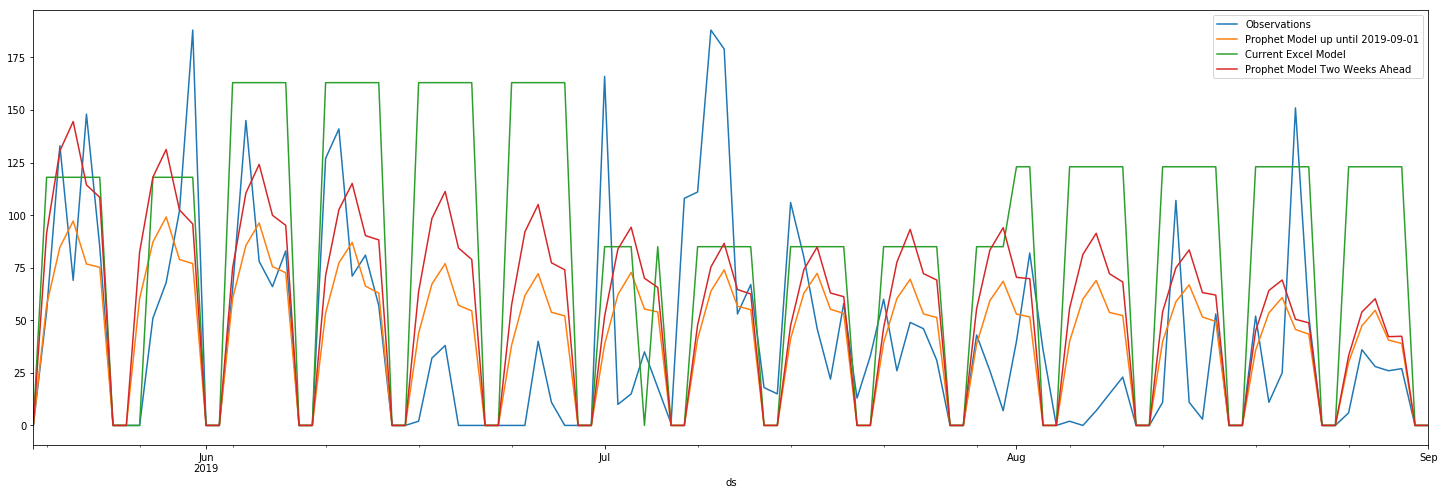

In [56]:

_, ax = plt.subplots(figsize=(25,8))
ito_verif_comp.loc[:,['Observations',f'Prophet Model up until {split_date}'\
                  ,'Current Excel Model','Prophet Model Two Weeks Ahead']].plot(ax=ax)
# ax.fill_between(verif_comp.index, verif_comp.loc[:,'yhat_lower'], verif_comp.loc[:,'yhat_upper'], color='coral', alpha=0.3)


print('MAPE of the Current Model ' + str(np.mean(np.abs(ito_verif_comp['Current Excel Model'] - ito_verif_comp['Observations'])/ito_verif_comp['Observations'].replace(0, np.nan))))
print(f'MAPE of the Prophet Model Up Until {split_date}  ' + str(np.mean(np.abs(ito_verif_comp[f'Prophet Model up until {split_date}'] - ito_verif_comp['Observations'])/ito_verif_comp['Observations'].replace(0, np.nan))))
print(f'MAPE of the Prophet Model Two Weeks Prediction  ' + str(np.mean(np.abs(ito_verif_comp['Prophet Model Two Weeks Ahead'] - ito_verif_comp['Observations'])/ito_verif_comp['Observations'].replace(0, np.nan))))


In [57]:
(np.abs(ito_verif_comp['Prophet Model Two Weeks Ahead'].replace(0, np.nan) - ito_verif_comp['Observations'].replace(0, np.nan))/ito_verif_comp['Observations'].replace(0, np.nan)).sort_values(ascending=False)

ds
2019-06-17    30.811229
2019-08-05    26.879046
2019-08-15    20.055326
2019-07-31    12.435245
2019-08-07    12.050831
2019-07-02     7.383264
2019-08-14     6.587892
2019-06-27     6.030694
2019-07-03     5.283771
2019-08-20     4.833759
2019-08-26     4.516756
2019-08-12     3.910302
2019-08-08     3.808970
2019-07-05     2.646050
2019-07-30     2.206492
2019-06-18     2.074685
2019-07-23     1.985932
2019-08-09     1.964856
2019-06-19     1.927756
2019-07-18     1.862794
2019-08-21     1.766290
2019-06-26     1.626282
2019-05-28     1.315147
2019-07-26     1.230429
2019-08-28     1.151896
2019-05-22     1.094477
2019-07-04     0.999590
2019-05-29     0.929914
2019-07-24     0.902548
2019-07-17     0.844449
                ...    
2019-06-15          NaN
2019-06-16          NaN
2019-06-20          NaN
2019-06-21          NaN
2019-06-22          NaN
2019-06-23          NaN
2019-06-24          NaN
2019-06-25          NaN
2019-06-28          NaN
2019-06-29          NaN
2019-06-30   

In [58]:
# REMOVE TOP 3 OUTLIERS SKEWING MAPE RESULTS
adj_ito_verif_comp = ito_verif_comp[~ito_verif_comp.index.isin(['2019-06-17','2019-07-02','2019-06-27'])]

# RECALCULATE MAPE RESULTS w/o OUTLIERS
print('MAPE of the Current Model ' + str(np.mean(np.abs(adj_ito_verif_comp['Current Excel Model'].replace(0, np.nan) - adj_ito_verif_comp['Observations'].replace(0, np.nan))/adj_ito_verif_comp['Observations'].replace(0, np.nan))))
print(f'MAPE of the Prophet Model Up Until {split_date}  ' + str(np.mean(np.abs(adj_ito_verif_comp[f'Prophet Model up until {split_date}'].replace(0, np.nan) - adj_ito_verif_comp['Observations'].replace(0, np.nan))/adj_ito_verif_comp['Observations'].replace(0, np.nan))))
print(f'MAPE of the Prophet Model Two Weeks Prediction  ' + str(np.mean(np.abs(adj_ito_verif_comp['Prophet Model Two Weeks Ahead'].replace(0, np.nan) - adj_ito_verif_comp['Observations'].replace(0, np.nan))/adj_ito_verif_comp['Observations'].replace(0, np.nan))))


MAPE of the Current Model 4.123956643320739
MAPE of the Prophet Model Up Until 2019-09-01  1.596928058198669
MAPE of the Prophet Model Two Weeks Prediction  2.1630428967856723


## G. FB Prophet Model - Outbound Vendor Returns

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
IN

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

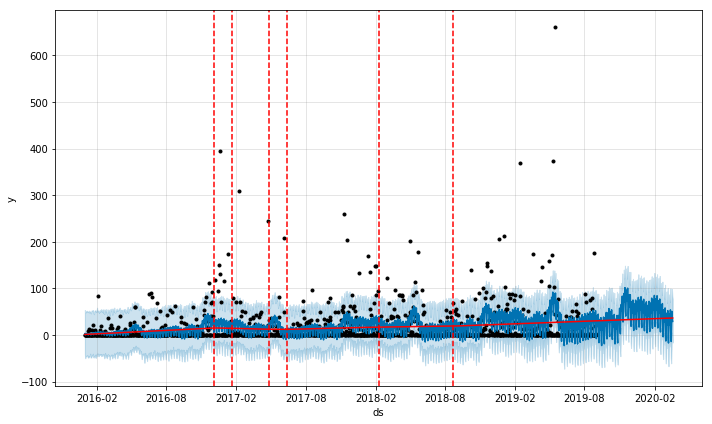

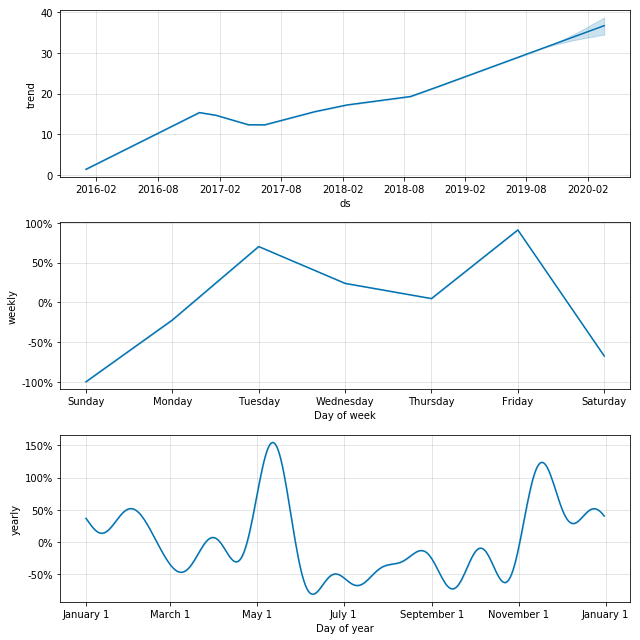

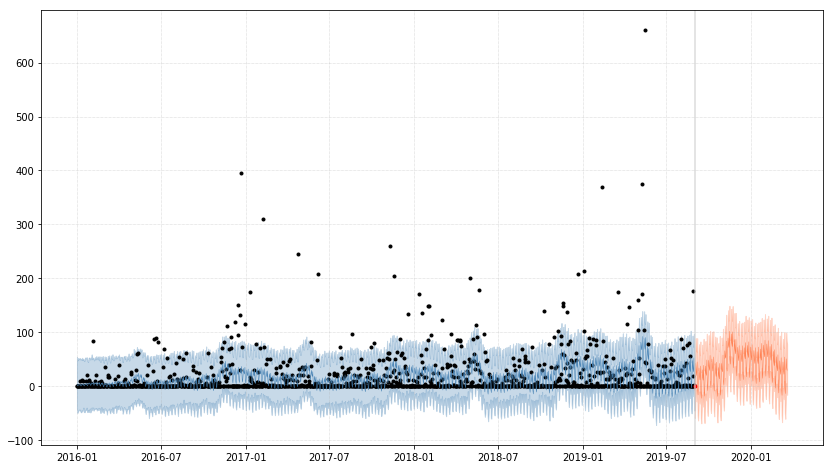

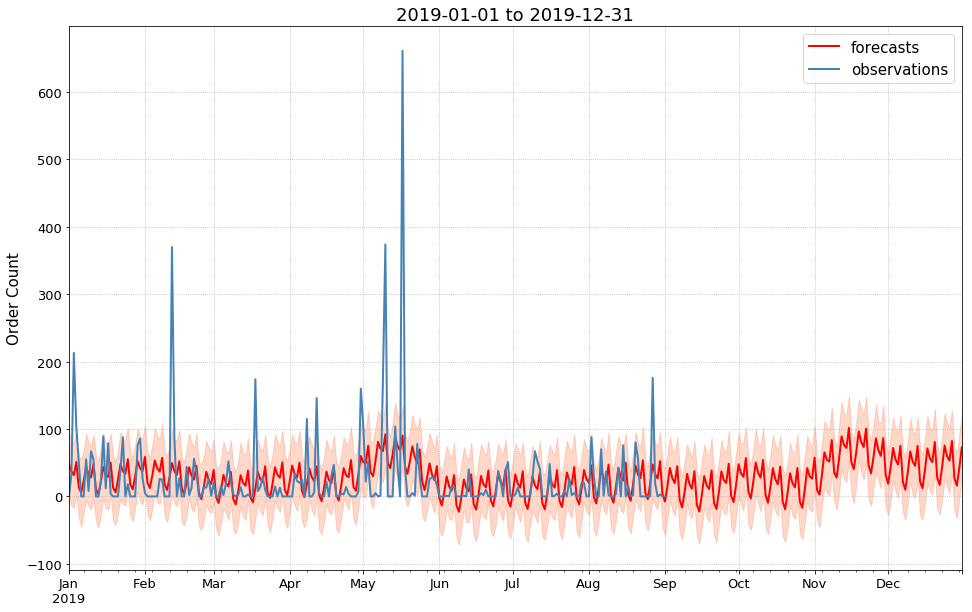

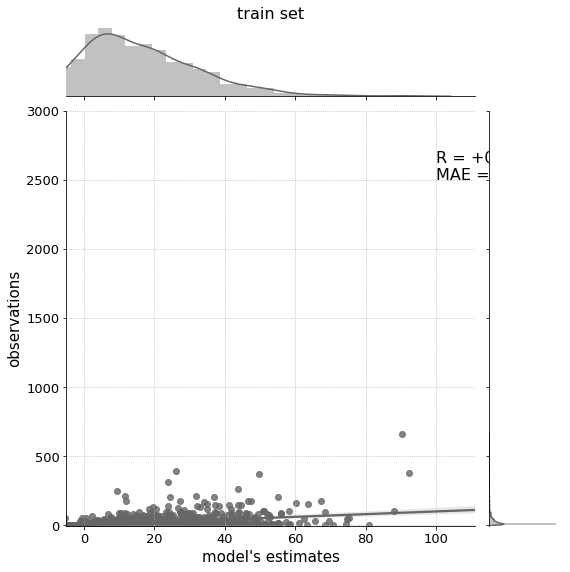

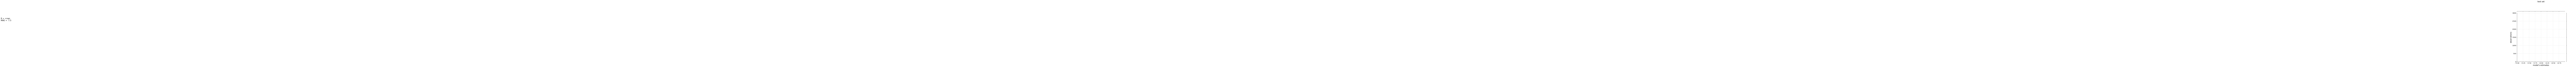

In [59]:
vr_m = Prophet(changepoint_prior_scale=0.1, changepoint_range=0.9 ,\
            seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
            holidays_prior_scale = 10, \
            yearly_seasonality=True, \
            weekly_seasonality=True, \
            daily_seasonality=False \
           #,holidays = vr_holidays
           )

vr_m_full = Prophet(changepoint_prior_scale=0.1, changepoint_range=0.9 ,\
            seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
            holidays_prior_scale = 10, \
            yearly_seasonality=True, \
            weekly_seasonality=True, \
            daily_seasonality=False \
           #,holidays = vr_holidays
           )

# fit the model
vr_m.fit(vr_dat_train)
vr_m_full.fit(vr_dat_all)

# predict forward_days 
vr_future = vr_m.make_future_dataframe(periods=len(vr_dat_test)+forward_days, freq='1D')
vr_forecast = vr_m.predict(vr_future)
vr_forecast.loc[vr_forecast.ds>=split_date,:].head()

# components showing
vr_m_full.component_modes

## Validation
fig = vr_m.plot(vr_forecast)
a = add_changepoints_to_plot(fig.gca(), vr_m, vr_forecast)


f = vr_m.plot_components(vr_forecast)


vr_verif = utils.make_verif(vr_forecast, vr_dat_train, vr_dat_test)
f = utils.plot_verif(vr_verif,date=split_date)


f, ax = plt.subplots(nrows=1, figsize=(16,10), sharey=True)
utils.make_plot_block(vr_verif, '2019-01-01', '2019-12-31', ax=ax)


utils.plot_joint_plot(vr_verif.loc[vr_verif.index<split_date,:], title='train set', fname=None)

utils.plot_joint_plot(vr_verif.loc[(vr_verif.index>=split_date) &(vr_verif['y'].notnull()) ,:], \
                      title='test set', fname=None)

## Cross Validation
df_cv = cross_validation(vr_m_full, initial='1210 days', period='7 days', horizon = '14 days')
df_cv_two_week = cross_validation(vr_m_full, initial='1210 days', period='1 days', horizon = '14 days')

df_cv['horizon'] = df_cv['ds']  - df_cv['cutoff']
df_cv['mape'] = np.abs(df_cv['yhat'] - df_cv['y'])/ df_cv['y']
df_cv = df_cv.loc[df_cv.mape<1,:]
df_p = performance_metrics(df_cv, rolling_window=0.1)
df_p.head()

df_cv_two_week['horizon'] = df_cv_two_week['ds']  - df_cv_two_week['cutoff']
df_two_week_prediction = df_cv_two_week.loc[df_cv_two_week.horizon=='14 days',:]
df_two_week_prediction.index = df_two_week_prediction.ds
df_two_week_prediction.drop(columns="ds", inplace=True)

df_1_day_prediction = df_cv_two_week.loc[df_cv_two_week.horizon=='1 days',:]
df_1_day_prediction.index = df_1_day_prediction["ds"]
df_1_day_prediction.drop(columns="ds", inplace=True)



MAPE of the Prophet Model Up Until 2019-09-01  4.964306018579929
MAPE of the Prophet Model Two Weeks Prediction  6.682531176922911


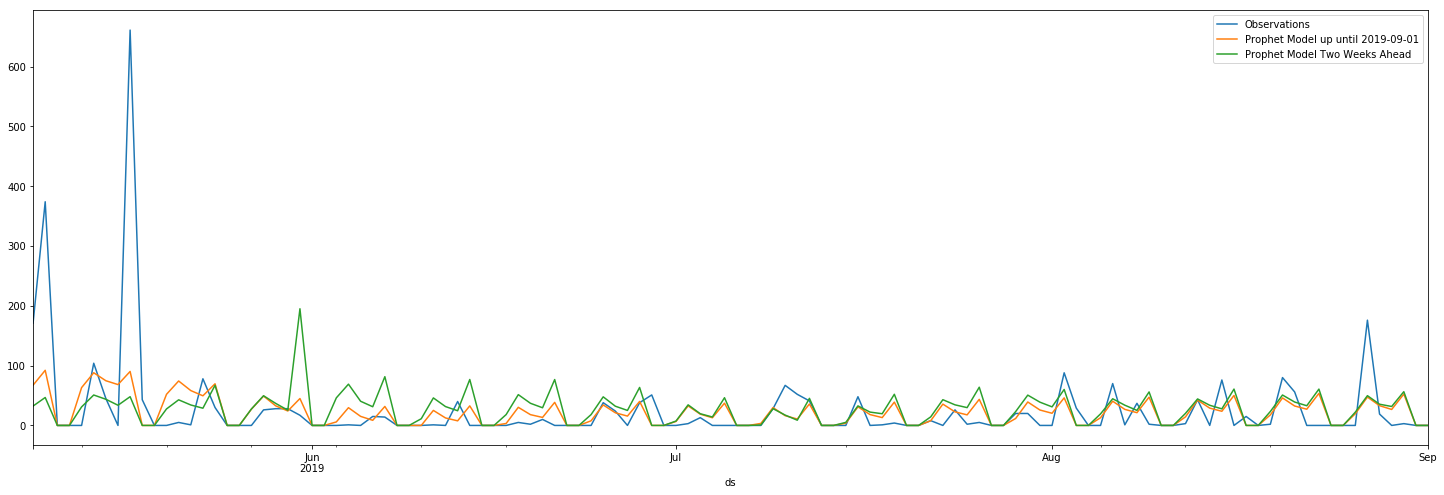

In [60]:

vr_verif_comp = pd.concat([vr_verif], axis=1, join='inner').\
filter(items=['yhat_lower','yhat_upper','yhat','y','excel_forecast'])
vr_verif_comp = vr_verif_comp.loc[vr_verif_comp['y'].notnull() ,:]
vr_verif_comp.rename(columns ={'y':'Observations' , 'yhat':f'Prophet Model up until {split_date}'} ,inplace=True)

vr_verif_comp = vr_verif_comp.merge(right = df_two_week_prediction, on="ds" ,how = "inner", suffixes=('',"_2w"))
vr_verif_comp.rename(columns ={'yhat':'Prophet Model Two Weeks Ahead'} ,inplace=True)

# if weekend then make it 0
vr_verif_comp['weekend'] = ((pd.DatetimeIndex(vr_verif_comp.index).dayofweek) // 5 == 1).astype(float)
vr_verif_comp.loc[vr_verif_comp['weekend'] > 0.0, 'Prophet Model Two Weeks Ahead'] = 0
vr_verif_comp.loc[vr_verif_comp['weekend'] > 0.0, f'Prophet Model up until {split_date}'] = 0

# if negative then make it 0
vr_verif_comp.loc[vr_verif_comp['Prophet Model Two Weeks Ahead'] < 0.0, 'Prophet Model Two Weeks Ahead'] = 0
vr_verif_comp.loc[vr_verif_comp[f'Prophet Model up until {split_date}'] < 0.0, f'Prophet Model up until {split_date}'] = 0

#verif_comp.head()

_, ax = plt.subplots(figsize=(25,8))
vr_verif_comp.loc[:,['Observations',f'Prophet Model up until {split_date}'\
                  ,'Prophet Model Two Weeks Ahead']].plot(ax=ax)
# ax.fill_between(verif_comp.index, verif_comp.loc[:,'yhat_lower'], verif_comp.loc[:,'yhat_upper'], color='coral', alpha=0.3)

print(f'MAPE of the Prophet Model Up Until {split_date}  ' + str(np.mean(np.abs(vr_verif_comp[f'Prophet Model up until {split_date}'] - vr_verif_comp['Observations'])/vr_verif_comp['Observations'].replace(0, np.nan))))
print(f'MAPE of the Prophet Model Two Weeks Prediction  ' + str(np.mean(np.abs(vr_verif_comp['Prophet Model Two Weeks Ahead'] - vr_verif_comp['Observations'])/vr_verif_comp['Observations'].replace(0, np.nan))))


In [61]:
(np.abs(vr_verif_comp['Prophet Model Two Weeks Ahead'].replace(0, np.nan) - vr_verif_comp['Observations'].replace(0, np.nan))/vr_verif_comp['Observations'].replace(0, np.nan)).sort_values(ascending=False)

ds
2019-06-04    68.008932
2019-06-11    44.997276
2019-05-22    33.204243
2019-08-07    32.835441
2019-08-09    27.000456
2019-07-18    18.551877
2019-08-30    17.806626
2019-06-19    17.528357
2019-07-25    13.887826
2019-07-19    12.018496
2019-07-26    11.779309
2019-08-19    10.687626
2019-05-31    10.475039
2019-07-02    10.473945
2019-06-18     9.297731
2019-05-21     7.564956
2019-08-12     5.713470
2019-06-07     4.821900
2019-06-20     1.953897
2019-07-30     1.533881
2019-05-24     1.235159
2019-06-06     1.083355
2019-05-17     0.927295
2019-05-28     0.909002
2019-05-10     0.875124
2019-08-28     0.867591
2019-07-11     0.831809
2019-05-09     0.810485
2019-07-22     0.791477
2019-07-10     0.741746
                ...    
2019-07-07          NaN
2019-07-08          NaN
2019-07-13          NaN
2019-07-14          NaN
2019-07-15          NaN
2019-07-17          NaN
2019-07-20          NaN
2019-07-21          NaN
2019-07-23          NaN
2019-07-27          NaN
2019-07-28   

In [62]:
# REMOVE TOP 3 OUTLIERS SKEWING MAPE RESULTS
adj_vr_verif_comp = vr_verif_comp[~vr_verif_comp.index.isin(['2019-06-04','2019-06-11','2019-05-22'])]

# RECALCULATE MAPE RESULTS w/o OUTLIERS
#print('MAPE of the Current Model ' + str(np.mean(np.abs(adj_vr_verif_comp['Current Excel Model'].replace(0, np.nan) - adj_vr_verif_comp['Observations'].replace(0, np.nan))/adj_vr_verif_comp['Observations'].replace(0, np.nan))))
print(f'MAPE of the Prophet Model Up Until {split_date}  ' + str(np.mean(np.abs(adj_vr_verif_comp[f'Prophet Model up until {split_date}'].replace(0, np.nan) - adj_vr_verif_comp['Observations'].replace(0, np.nan))/adj_vr_verif_comp['Observations'].replace(0, np.nan))))
print(f'MAPE of the Prophet Model Two Weeks Prediction  ' + str(np.mean(np.abs(adj_vr_verif_comp['Prophet Model Two Weeks Ahead'].replace(0, np.nan) - adj_vr_verif_comp['Observations'].replace(0, np.nan))/adj_vr_verif_comp['Observations'].replace(0, np.nan))))


MAPE of the Prophet Model Up Until 2019-09-01  3.377836786844138
MAPE of the Prophet Model Two Weeks Prediction  4.613876510252314


## H. FB Prophet Model - Outbound Transfer Orders

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
IN

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

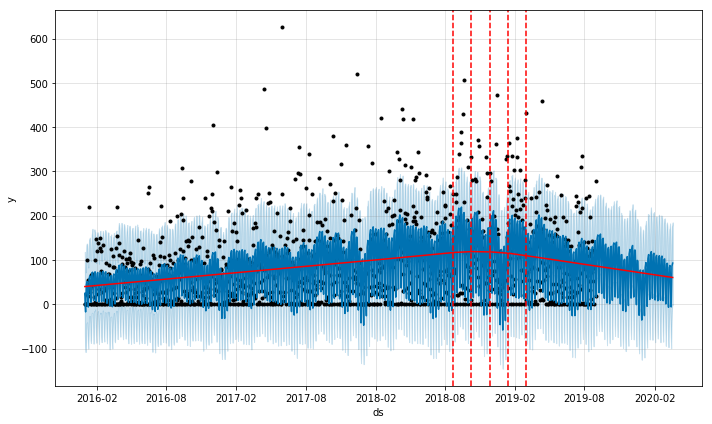

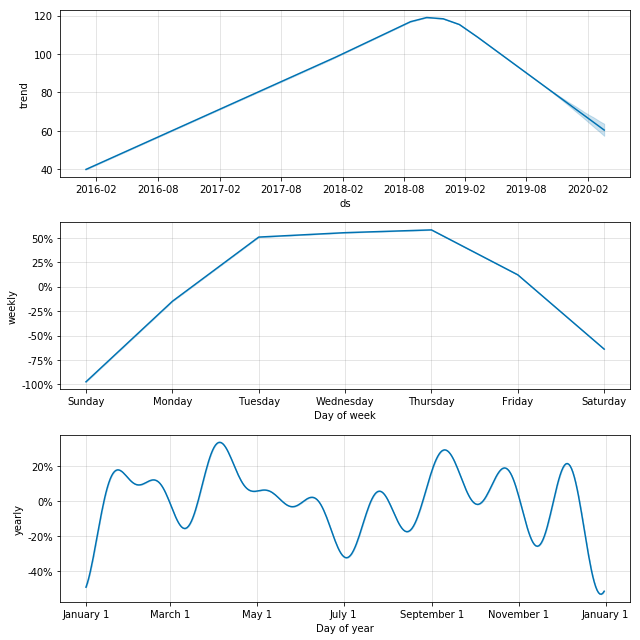

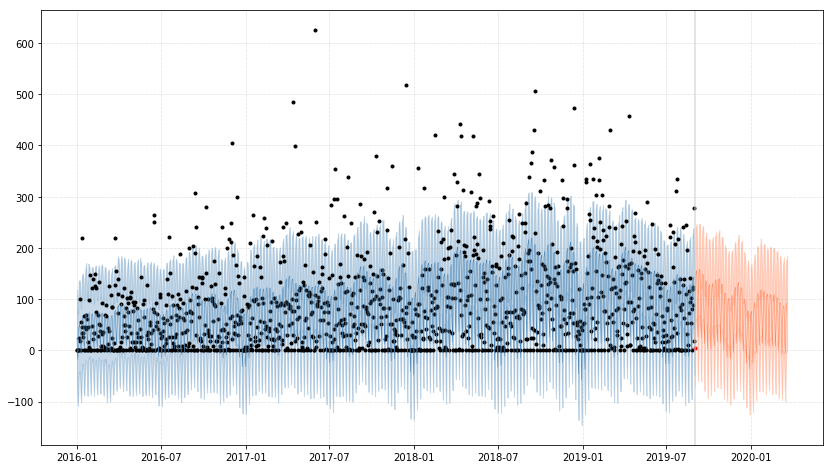

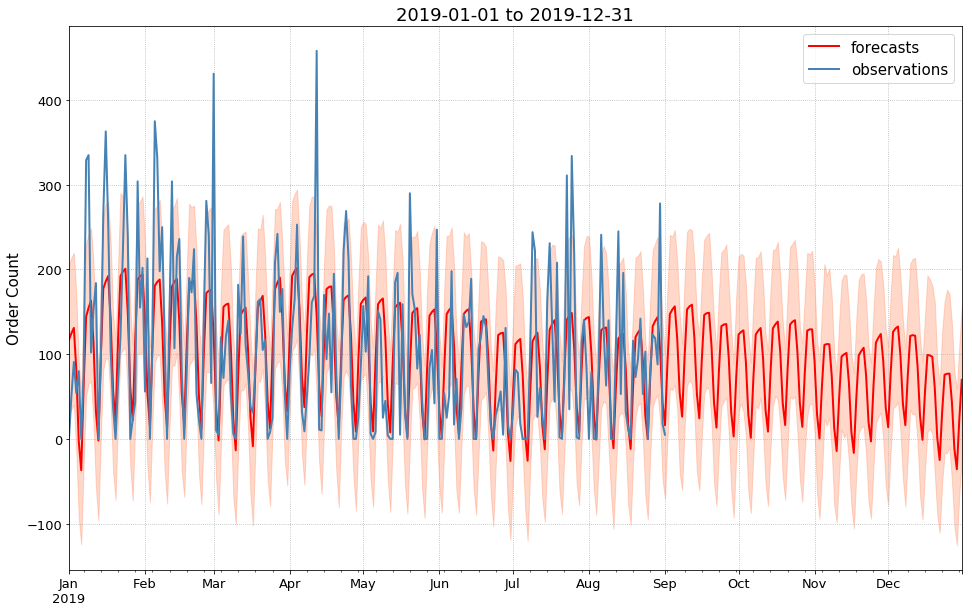

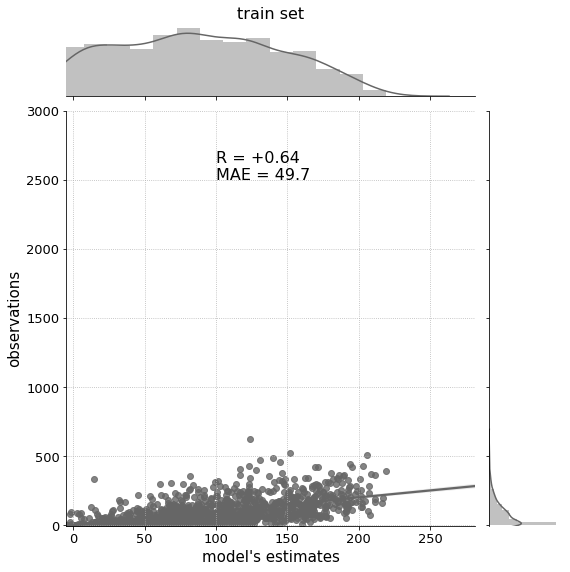

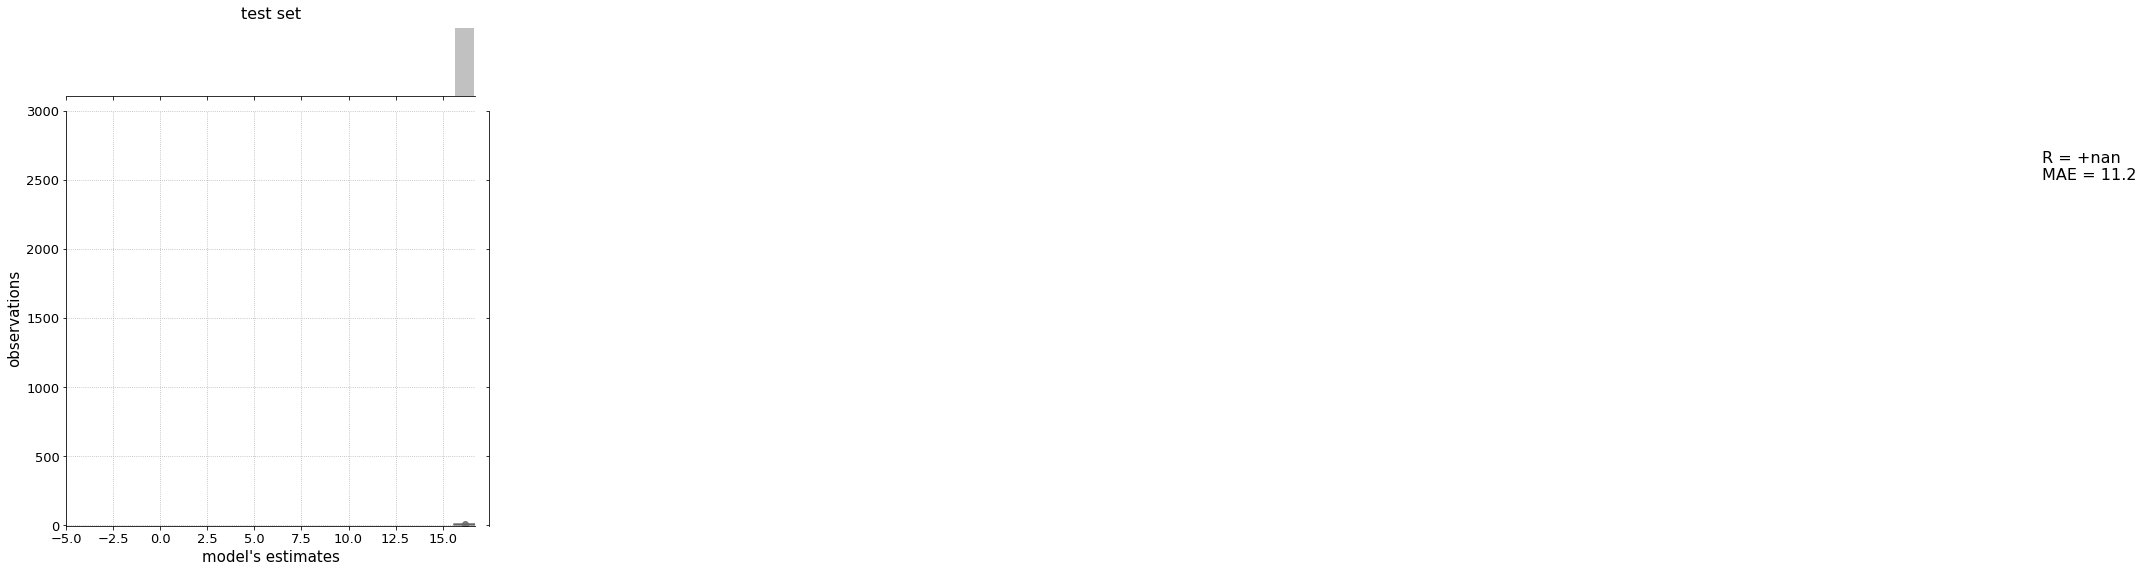

In [63]:
oto_m = Prophet(changepoint_prior_scale=0.1, changepoint_range=0.9 ,\
            seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
            holidays_prior_scale = 10, \
            yearly_seasonality=True, \
            weekly_seasonality=True, \
            daily_seasonality=False \
           #,holidays = oto_holidays
           )

oto_m_full = Prophet(changepoint_prior_scale=0.1, changepoint_range=0.9 ,\
            seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
            holidays_prior_scale = 10, \
            yearly_seasonality=True, \
            weekly_seasonality=True, \
            daily_seasonality=False \
           #,holidays = oto_holidays
           )

# fit the model
oto_m.fit(oto_dat_train)
oto_m_full.fit(oto_dat_all)

# predict forward_days 
oto_future = oto_m.make_future_dataframe(periods=len(oto_dat_test)+forward_days, freq='1D')
oto_forecast = oto_m.predict(oto_future)
oto_forecast.loc[oto_forecast.ds>=split_date,:].head()

# components showing
oto_m_full.component_modes

## Validation
fig = oto_m.plot(oto_forecast)
a = add_changepoints_to_plot(fig.gca(), oto_m, oto_forecast)


f = oto_m.plot_components(oto_forecast)


oto_verif = utils.make_verif(oto_forecast, oto_dat_train, oto_dat_test)
f = utils.plot_verif(oto_verif,date=split_date)


f, ax = plt.subplots(nrows=1, figsize=(16,10), sharey=True)
utils.make_plot_block(oto_verif, '2019-01-01', '2019-12-31', ax=ax)


utils.plot_joint_plot(oto_verif.loc[oto_verif.index<split_date,:], title='train set', fname=None)

utils.plot_joint_plot(oto_verif.loc[(oto_verif.index>=split_date) &(oto_verif['y'].notnull()) ,:], \
                      title='test set', fname=None)

## Cross Validation
df_cv = cross_validation(oto_m_full, initial='1210 days', period='7 days', horizon = '14 days')
df_cv_two_week = cross_validation(oto_m_full, initial='1210 days', period='1 days', horizon = '14 days')

df_cv['horizon'] = df_cv['ds']  - df_cv['cutoff']
df_cv['mape'] = np.abs(df_cv['yhat'] - df_cv['y'])/ df_cv['y']
df_cv = df_cv.loc[df_cv.mape<1,:]
df_p = performance_metrics(df_cv, rolling_window=0.1)
df_p.head()

df_cv_two_week['horizon'] = df_cv_two_week['ds']  - df_cv_two_week['cutoff']
df_two_week_prediction = df_cv_two_week.loc[df_cv_two_week.horizon=='14 days',:]
df_two_week_prediction.index = df_two_week_prediction.ds
df_two_week_prediction.drop(columns="ds", inplace=True)

df_1_day_prediction = df_cv_two_week.loc[df_cv_two_week.horizon=='1 days',:]
df_1_day_prediction.index = df_1_day_prediction["ds"]
df_1_day_prediction.drop(columns="ds", inplace=True)

oto_verif_comp = pd.concat([oto_dat_curr_prediction, oto_verif], axis=1, join='inner').\
filter(items=['yhat_lower','yhat_upper','yhat','y','excel_forecast'])
oto_verif_comp = oto_verif_comp.loc[oto_verif_comp['y'].notnull() ,:]
oto_verif_comp.rename(columns ={'y':'Observations' , 'yhat':f'Prophet Model up until {split_date}', 'excel_forecast':'Current Excel Model'} ,inplace=True)

oto_verif_comp = oto_verif_comp.merge(right = df_two_week_prediction, on="ds" ,how = "inner", suffixes=('',"_2w"))
oto_verif_comp.rename(columns ={'yhat':'Prophet Model Two Weeks Ahead'} ,inplace=True)

# if weekend then make it 0
oto_verif_comp['weekend'] = ((pd.DatetimeIndex(oto_verif_comp.index).dayofweek) // 5 == 1).astype(float)
oto_verif_comp.loc[oto_verif_comp['weekend'] > 0.0, 'Prophet Model Two Weeks Ahead'] = 0
oto_verif_comp.loc[oto_verif_comp['weekend'] > 0.0, f'Prophet Model up until {split_date}'] = 0

# if negative then make it 0
oto_verif_comp.loc[oto_verif_comp['Prophet Model Two Weeks Ahead'] < 0.0, 'Prophet Model Two Weeks Ahead'] = 0
oto_verif_comp.loc[oto_verif_comp[f'Prophet Model up until {split_date}'] < 0.0, f'Prophet Model up until {split_date}'] = 0


MAPE of the Current Model 3.250120527715328
MAPE of the Prophet Model Up Until 2019-09-01  1.169338452036312
MAPE of the Prophet Model Two Weeks Prediction  1.2254571818225484


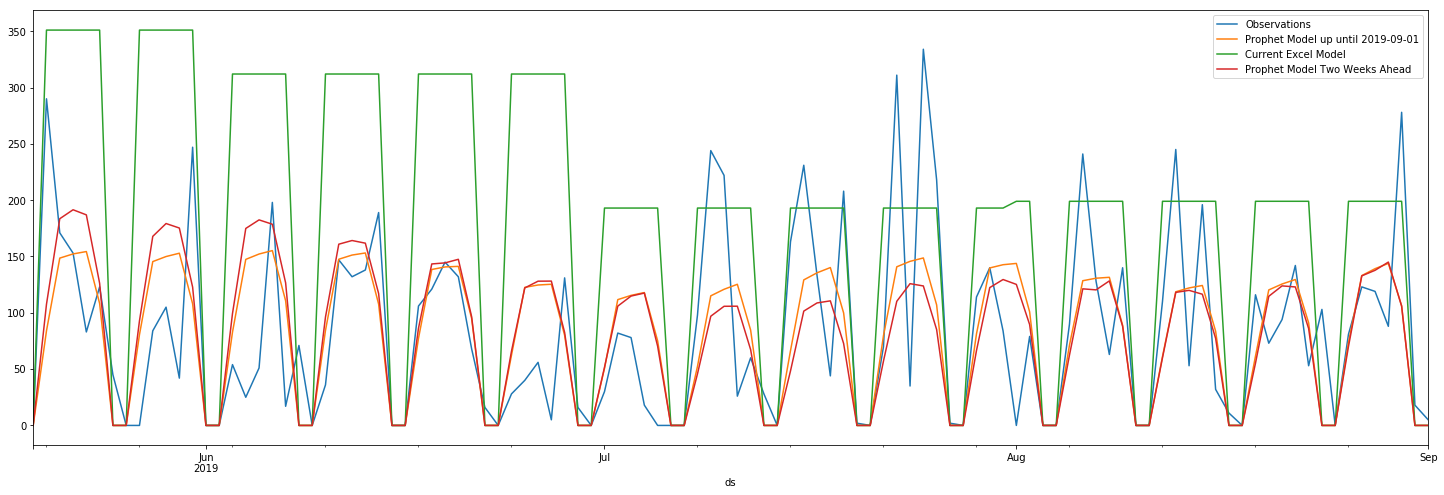

In [64]:

_, ax = plt.subplots(figsize=(25,8))
oto_verif_comp.loc[:,['Observations',f'Prophet Model up until {split_date}'\
                  ,'Current Excel Model','Prophet Model Two Weeks Ahead']].plot(ax=ax)
# ax.fill_between(verif_comp.index, verif_comp.loc[:,'yhat_lower'], verif_comp.loc[:,'yhat_upper'], color='coral', alpha=0.3)


print('MAPE of the Current Model ' + str(np.mean(np.abs(oto_verif_comp['Current Excel Model'].replace(0, np.nan) - oto_verif_comp['Observations'].replace(0, np.nan))/oto_verif_comp['Observations'].replace(0, np.nan))))
print(f'MAPE of the Prophet Model Up Until {split_date}  ' + str(np.mean(np.abs(oto_verif_comp[f'Prophet Model up until {split_date}'].replace(0, np.nan) - oto_verif_comp['Observations'].replace(0, np.nan))/oto_verif_comp['Observations'].replace(0, np.nan))))
print(f'MAPE of the Prophet Model Two Weeks Prediction  ' + str(np.mean(np.abs(oto_verif_comp['Prophet Model Two Weeks Ahead'].replace(0, np.nan) - oto_verif_comp['Observations'].replace(0, np.nan))/oto_verif_comp['Observations'].replace(0, np.nan))))


In [65]:
(np.abs(oto_verif_comp['Prophet Model Two Weeks Ahead'].replace(0, np.nan) - oto_verif_comp['Observations'].replace(0, np.nan))/oto_verif_comp['Observations'].replace(0, np.nan)).sort_values(ascending=False)

ds
2019-06-27    24.628756
2019-06-07     6.447173
2019-06-04     5.995548
2019-07-04     5.529022
2019-05-30     3.173029
2019-07-11     3.071810
2019-07-24     2.596191
2019-06-05     2.578327
2019-06-25     2.051901
2019-06-10     1.673651
2019-07-18     1.513716
2019-08-16     1.416003
2019-06-24     1.353280
2019-06-26     1.286979
2019-08-14     1.262926
2019-05-23     1.252456
2019-08-08     1.036438
2019-05-28     0.998399
2019-06-03     0.839067
2019-07-01     0.718802
2019-05-29     0.707157
2019-07-15     0.703561
2019-07-19     0.650374
2019-08-29     0.648079
2019-07-23     0.645670
2019-07-25     0.629249
2019-05-20     0.628906
2019-08-23     0.624317
2019-08-30     0.619216
2019-07-26     0.609594
                ...    
2019-06-01          NaN
2019-06-02          NaN
2019-06-08          NaN
2019-06-09          NaN
2019-06-15          NaN
2019-06-16          NaN
2019-06-22          NaN
2019-06-23          NaN
2019-06-29          NaN
2019-06-30          NaN
2019-07-05   

In [66]:
# REMOVE TOP 3 OUTLIERS SKEWING MAPE RESULTS
adj_oto_verif_comp = oto_verif_comp[~oto_verif_comp.index.isin(['2019-06-27','2019-06-07','2019-06-04'])]

# RECALCULATE MAPE RESULTS w/o OUTLIERS
print('MAPE of the Current Model ' + str(np.mean(np.abs(adj_oto_verif_comp['Current Excel Model'].replace(0, np.nan) - adj_oto_verif_comp['Observations'].replace(0, np.nan))/adj_oto_verif_comp['Observations'].replace(0, np.nan))))
print(f'MAPE of the Prophet Model Up Until {split_date}  ' + str(np.mean(np.abs(adj_oto_verif_comp[f'Prophet Model up until {split_date}'].replace(0, np.nan) - adj_oto_verif_comp['Observations'].replace(0, np.nan))/adj_oto_verif_comp['Observations'].replace(0, np.nan))))
print(f'MAPE of the Prophet Model Two Weeks Prediction  ' + str(np.mean(np.abs(adj_oto_verif_comp['Prophet Model Two Weeks Ahead'].replace(0, np.nan) - adj_oto_verif_comp['Observations'].replace(0, np.nan))/adj_oto_verif_comp['Observations'].replace(0, np.nan))))


MAPE of the Current Model 2.083706330710624
MAPE of the Prophet Model Up Until 2019-09-01  0.7205160911100944
MAPE of the Prophet Model Two Weeks Prediction  0.7414701564120647


# --FINAL FB Prophet Ensemble Outputs--

In [67]:
co_forecast.loc[ co_forecast['yhat'] < 0.0, 'yhat'] = 0
po_forecast.loc[ po_forecast['yhat'] < 0.0, 'yhat'] = 0
cr_forecast.loc[ cr_forecast['yhat'] < 0.0, 'yhat'] = 0
ito_forecast.loc[ito_forecast['yhat'] < 0.0, 'yhat'] = 0
oto_forecast.loc[oto_forecast['yhat'] < 0.0, 'yhat'] = 0
vr_forecast.loc[ vr_forecast['yhat'] < 0.0, 'yhat'] = 0

co_ensemble  =  co_forecast[['ds','yhat']]
po_ensemble  =  po_forecast[['ds','yhat']]
cr_ensemble  =  cr_forecast[['ds','yhat']]
ito_ensemble = ito_forecast[['ds','yhat']]
oto_ensemble = oto_forecast[['ds','yhat']]
vr_ensemble  =  vr_forecast[['ds','yhat']]

co_ensemble.rename(columns  ={'ds':'date_est','yhat':'fcst_out_co'} ,inplace=True)  
po_ensemble.rename(columns  ={'yhat':'fcst_in_po'} ,inplace=True)   
cr_ensemble.rename(columns  ={'yhat':'fcst_in_cr'} ,inplace=True)   
ito_ensemble.rename(columns ={'yhat':'fcst_in_ito'} ,inplace=True)  
oto_ensemble.rename(columns ={'yhat':'fcst_out_oto'} ,inplace=True)  
vr_ensemble.rename(columns  ={'yhat':'fcst_out_vr'} ,inplace=True)   

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [68]:
# join outputs


dfs = [co_ensemble[['date_est','fcst_out_co']] \
      ,po_ensemble[['ds','fcst_in_po']] \
      ,cr_ensemble[['ds','fcst_in_cr']] \
      ,ito_ensemble[['ds','fcst_in_ito']] \
      ,oto_ensemble[['ds','fcst_out_oto']] \
      ,vr_ensemble[['ds','fcst_out_vr']]] 
nan_value = 0

fcst_ensemble = pd.concat(dfs, join='outer', axis=1).fillna(nan_value)
fcst_ensemble.drop(columns=['ds'], inplace = True)


#create total columns
fcst_ensemble['fcst_total_ins'] =    fcst_ensemble['fcst_in_cr'] \
                                   + fcst_ensemble['fcst_in_po'] \
                                   + fcst_ensemble['fcst_in_ito']

fcst_ensemble['fcst_total_outs'] =   fcst_ensemble['fcst_out_co'] \
                                   + fcst_ensemble['fcst_out_oto'] \
                                   + fcst_ensemble['fcst_out_vr'] \

fcst_ensemble['fcst_total_flow'] =   fcst_ensemble['fcst_out_co'] \
                                   + fcst_ensemble['fcst_out_oto'] \
                                   + fcst_ensemble['fcst_out_vr'] \
                                   + fcst_ensemble['fcst_in_cr'] \
                                   + fcst_ensemble['fcst_in_po'] \
                                   + fcst_ensemble['fcst_in_ito']

fcst_ensemble['fcst_total_flow_adj'] = fcst_ensemble['fcst_out_co'] \
                                   + fcst_ensemble['fcst_out_oto'] \
                                   + fcst_ensemble['fcst_in_cr'] \
                                   + fcst_ensemble['fcst_in_po'] \
                                   + fcst_ensemble['fcst_in_ito'] 

In [69]:
display(fcst_ensemble.head())
display(fcst_ensemble.tail())

date_est  fcst_out_co  fcst_in_po  fcst_in_cr  fcst_in_ito  fcst_out_oto  \
0 2016-01-01   263.685221  272.291665  213.742364    35.079595     24.590134   
1 2016-01-02   246.149505   55.061769  295.910211     0.000000      0.000000   
2 2016-01-03   193.007616    0.000000  122.460438     0.000000      0.000000   
3 2016-01-04   328.797918  251.940329    7.227028    26.837771     16.946219   
4 2016-01-05   366.475834  255.811107   70.590300    42.375881     44.857179   

   fcst_out_vr  fcst_total_ins  fcst_total_outs  fcst_total_flow  \
0     3.205499      521.113624       291.480853       812.594477   
1     0.982759      350.971980       247.132264       598.104244   
2     0.486258      122.460438       193.493874       315.954311   
3     1.632075      286.005129       347.376212       633.381341   
4     3.069926      368.777287       414.402938       783.180226   

   fcst_total_flow_adj  
0           809.388978  
1           597.121485  
2           315.468053  
3           631.749266  
4           780.110300

date_est  fcst_out_co  fcst_in_po   fcst_in_cr  fcst_in_ito  \
1535 2020-03-15  1130.025215         0.0    32.102468          0.0   
1536 2020-03-16  1170.938839         0.0   600.139460          0.0   
1537 2020-03-17  1193.934525         0.0  1071.315517          0.0   
1538 2020-03-18  1648.551861         0.0  1128.717943          0.0   
1539 2020-03-19  1542.821346         0.0  1040.947845          0.0   

      fcst_out_oto  fcst_out_vr  fcst_total_ins  fcst_total_outs  \
1535      0.000000     0.000000       32.102468      1130.025215   
1536     44.954266    15.651580      600.139460      1231.544685   
1537     85.963577    50.637922     1071.315517      1330.536023   
1538     89.913552    35.015843     1128.717943      1773.481256   
1539     92.996983    29.388254     1040.947845      1665.206583   

      fcst_total_flow  fcst_total_flow_adj  
1535      1162.127684          1162.127684  
1536      1831.684145          1816.032565  
1537      2401.851541          2351.213619  
1538      2902.199199          2867.183356  
1539      2706.154428          2676.766174

In [70]:
data_raw_all.head()

date_est  OUT_CUST_UNITS  OUT_TO_UNITS  OUT_VR_UNITS  IN_CUST_UNITS  \
0 2016-01-01             256           0.0           0.0           19.0   
1 2016-01-02             228           0.0           0.0            0.0   
2 2016-01-03             208           0.0           0.0            0.0   
3 2016-01-04             235           1.0           0.0          134.0   
4 2016-01-05             362          24.0           0.0          112.0   

   IN_PO_UNITS  IN_TO_UNITS  TTL_OUT_UNITS  TTL_IN_UNITS  TTL_ALL_UNITS  
0          0.0          0.0            256            19            275  
1          0.0          0.0            228             0            228  
2          0.0          0.0            208             0            208  
3        264.0          0.0            236           398            634  
4        338.0          0.0            386           450            836

In [71]:
test_actuals  = data_raw_all.loc[data_raw_all.date_est>=split_date , :]
test_forecast = fcst_ensemble.loc[fcst_ensemble.date_est>=split_date , :]

test_actuals  = test_actuals.loc[test_actuals.date_est<='2019-07-23' , :]
test_forecast = test_forecast.loc[test_forecast.date_est<='2019-07-23' , :]

In [72]:
test_excel    = dat_curr_prediction.loc[dat_curr_prediction.FCST_Dt>=split_date , :]
test_excel    = test_excel.loc[test_excel.FCST_Dt<='2019-07-23' , :]

In [73]:
test_actuals_exc_adj = test_actuals
test_actuals_exc_adj['ADJ_TTL_ALL_UNITS'] = test_actuals['TTL_ALL_UNITS'] - test_actuals['OUT_VR_UNITS']

In [74]:
test_actuals = test_actuals.reset_index(drop=True)
test_forecast = test_forecast.reset_index(drop=True)
test_actuals_exc_adj = test_actuals_exc_adj.reset_index(drop=True)

display(test_actuals.head())
display(test_excel.head())
display(test_actuals_exc_adj.head())
display(test_forecast.head())

Empty DataFrame
Columns: [date_est, OUT_CUST_UNITS, OUT_TO_UNITS, OUT_VR_UNITS, IN_CUST_UNITS, IN_PO_UNITS, IN_TO_UNITS, TTL_OUT_UNITS, TTL_IN_UNITS, TTL_ALL_UNITS, ADJ_TTL_ALL_UNITS]
Index: []

Empty DataFrame
Columns: [FCST_Dt, FCT_IN_PO, FCT_IN_Return, FCT_IN_TO, FCT_IN_TOTAL, FCT_OUT_Ord, FCT_OUT_TO, FCT_OUT_TOTAL, FCT_TOTAL]
Index: []

Empty DataFrame
Columns: [date_est, OUT_CUST_UNITS, OUT_TO_UNITS, OUT_VR_UNITS, IN_CUST_UNITS, IN_PO_UNITS, IN_TO_UNITS, TTL_OUT_UNITS, TTL_IN_UNITS, TTL_ALL_UNITS, ADJ_TTL_ALL_UNITS]
Index: []

Empty DataFrame
Columns: [date_est, fcst_out_co, fcst_in_po, fcst_in_cr, fcst_in_ito, fcst_out_oto, fcst_out_vr, fcst_total_ins, fcst_total_outs, fcst_total_flow, fcst_total_flow_adj]
Index: []

In [75]:
print(f'MAPE of the Prophet Model ' \
      + str(np.mean(np.abs(test_forecast['fcst_total_flow'] \
      - test_actuals['TTL_ALL_UNITS']) \
      / test_actuals['TTL_ALL_UNITS'])))

print(f'MAE of the Prophet Model ' \
      + str(np.mean(np.abs(test_forecast['fcst_total_flow'] \
      - test_actuals['TTL_ALL_UNITS']))))

MAPE of the Prophet Model nan
MAE of the Prophet Model nan


In [76]:
print(f'MAPE of the Prophet Model ' \
      + str(np.mean(np.abs(test_forecast['fcst_total_outs'] \
      - test_actuals['TTL_OUT_UNITS']) \
      / test_actuals['TTL_OUT_UNITS'])))

print(f'MAE of the Prophet Model ' \
      + str(np.mean(np.abs(test_forecast['fcst_total_outs'] \
      - test_actuals['TTL_OUT_UNITS']))))


print(f'MAPE of the Prophet Model ' \
      + str(np.mean(np.abs(test_forecast['fcst_total_ins'].replace(0, np.nan) \
      - test_actuals['TTL_IN_UNITS'].replace(0, np.nan)) \
      / test_actuals['TTL_IN_UNITS'].replace(0, np.nan))))

print(f'MAE of the Prophet Model ' \
      + str(np.mean(np.abs(test_forecast['fcst_total_ins'] \
      - test_actuals['TTL_IN_UNITS']))))


MAPE of the Prophet Model nan
MAE of the Prophet Model nan
MAPE of the Prophet Model nan
MAE of the Prophet Model nan


In [77]:
print(f'MAPE of the Excel Model ' \
      + str(np.mean(np.abs(test_excel['FCT_TOTAL'] \
      - test_actuals_exc_adj['ADJ_TTL_ALL_UNITS']) \
      / test_actuals_exc_adj['ADJ_TTL_ALL_UNITS'])))


MAPE of the Excel Model nan


In [78]:
print(f'MAPE of the Prophet Model ' \
      + str(np.mean(np.abs(test_forecast['fcst_total_flow_adj'] \
      - test_actuals_exc_adj['ADJ_TTL_ALL_UNITS']) \
      / test_actuals_exc_adj['ADJ_TTL_ALL_UNITS'])))


MAPE of the Prophet Model nan


In [79]:
display(fcst_ensemble.head())
display(fcst_ensemble.tail())

date_est  fcst_out_co  fcst_in_po  fcst_in_cr  fcst_in_ito  fcst_out_oto  \
0 2016-01-01   263.685221  272.291665  213.742364    35.079595     24.590134   
1 2016-01-02   246.149505   55.061769  295.910211     0.000000      0.000000   
2 2016-01-03   193.007616    0.000000  122.460438     0.000000      0.000000   
3 2016-01-04   328.797918  251.940329    7.227028    26.837771     16.946219   
4 2016-01-05   366.475834  255.811107   70.590300    42.375881     44.857179   

   fcst_out_vr  fcst_total_ins  fcst_total_outs  fcst_total_flow  \
0     3.205499      521.113624       291.480853       812.594477   
1     0.982759      350.971980       247.132264       598.104244   
2     0.486258      122.460438       193.493874       315.954311   
3     1.632075      286.005129       347.376212       633.381341   
4     3.069926      368.777287       414.402938       783.180226   

   fcst_total_flow_adj  
0           809.388978  
1           597.121485  
2           315.468053  
3           631.749266  
4           780.110300

date_est  fcst_out_co  fcst_in_po   fcst_in_cr  fcst_in_ito  \
1535 2020-03-15  1130.025215         0.0    32.102468          0.0   
1536 2020-03-16  1170.938839         0.0   600.139460          0.0   
1537 2020-03-17  1193.934525         0.0  1071.315517          0.0   
1538 2020-03-18  1648.551861         0.0  1128.717943          0.0   
1539 2020-03-19  1542.821346         0.0  1040.947845          0.0   

      fcst_out_oto  fcst_out_vr  fcst_total_ins  fcst_total_outs  \
1535      0.000000     0.000000       32.102468      1130.025215   
1536     44.954266    15.651580      600.139460      1231.544685   
1537     85.963577    50.637922     1071.315517      1330.536023   
1538     89.913552    35.015843     1128.717943      1773.481256   
1539     92.996983    29.388254     1040.947845      1665.206583   

      fcst_total_flow  fcst_total_flow_adj  
1535      1162.127684          1162.127684  
1536      1831.684145          1816.032565  
1537      2401.851541          2351.213619  
1538      2902.199199          2867.183356  
1539      2706.154428          2676.766174

In [80]:
# export data to bigquery
fcst_ensemble.to_gbq('adhoc_analytics.temp_test_py2bq',project_id='moda-operandi-dw',if_exists = 'replace')

1540 out of 1540 rows loaded._gbq.gbq:
1it [00:03,  3.07s/it]
